# July ??, 2021

**Motivation**: Mouse meeting presentation. <br>


In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
svinet_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/svinet')


# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.network import Network
from analysis.helper import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE



def hierarchical_compare(
        hierarchical: dict,
        n_clusters: Union[range, list],
        key_fx: str = 'sub-SLC',
        keys_mv: List[str] = None,
        dist_measure: str = 'dice',
        cmap='RdYlBu_r',
        figsize=None, ):
    
    allen = hierarchical[key_fx].mice.allen
    contour = hierarchical[key_fx].mice.parcel.results2d['contour']
    
    keys_mv = keys_mv if keys_mv else ['ses-1', 'ses-2', 'ses-3']
    nrows, ncols = len(keys_mv) + 1, len(n_clusters)
    figsize = figsize if figsize else (13.5, 1.75 * nrows)
    fig, axes = create_figure(nrows, ncols, figsize=figsize)

    match_results = {}
    for j, n in tqdm(enumerate(n_clusters), total=len(n_clusters), leave=False):
        fx_masks = hierarchical[key_fx].results[n]['cluster_masks']
        _, x2d = masks2cluster(fx_masks, allen)
        
        cond = np.logical_or(contour, x2d == 0)
        _cond, _x = filter_boundaries([cond, x2d], mask=x2d.astype(bool))
        data2plt = np.ma.masked_where(_cond, _x)
        axes[0, j].imshow(data2plt, cmap=cmap)
        axes[0, j].set_title(f"n = {n}", fontsize=17, y=1.06)
        if j == 0:
            axes[0, j].set_ylabel(f"{key_fx}\n", fontsize=15)

        for i, key in enumerate(keys_mv):
            mv_masks = hierarchical[key].results[n]['cluster_masks']
            scores, mappings = clusters_sim_scores(fx_masks, mv_masks, weighted=True)
            match_results['_vs_'.join([key_fx, key])] = (scores, mappings)

            algn_idxs = list(mappings[dist_measure].values())
            mv_algn = dict(zip(
                list(mv_masks),
                np.array(list(mv_masks.values()))[algn_idxs]
            ))
            _, x2d_algn = masks2cluster(mv_algn, allen)

            cond = np.logical_or(contour, x2d_algn == 0)
            _cond, _x = filter_boundaries([cond, x2d_algn], mask=x2d_algn.astype(bool))
            data2plt = np.ma.masked_where(_cond, _x)
            axes[i + 1, j].imshow(data2plt, cmap=cmap)
            if j == 0:
                axes[i + 1, j].set_ylabel(f"{key}\n", fontsize=14)
    remove_ticks(axes)
    return fig, axes, match_results

### Report # voxels per ROI in the individual space
### Report estimated # neurons per ROI in individual space
### Add a checker that makes sure each ROI mask has at least one nonzero voxel

## ROI definition

In [3]:
mice = Mice(Config(256))
mice.combine_dfs('rest')

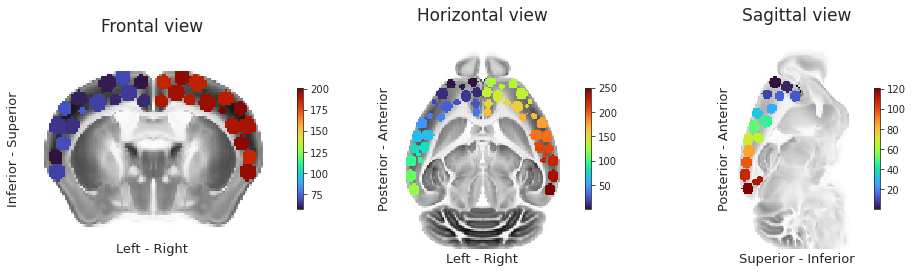

In [4]:
# HIDE CODE


space = AnatomicalSpace('asl')
fig, axes = create_figure(1, 3, figsize=(13, 3.9))

slice_idxs = [58, 30, 44]
for i, (ax, plane, labels) in enumerate(zip(axes, space.sections, space.axis_labels)):
    data2plt = mice.parcel.results['eroded'].take(slice_idxs[i], axis=i)
    data2plt = np.ma.masked_where(data2plt == 0, data2plt)
    ax.imshow(mice.allen['template'].take(slice_idxs[i], axis=i), cmap='Greys')
    im = ax.imshow(data2plt, cmap='turbo')
    plt.colorbar(im, ax=ax, shrink=0.6)
    
    ax.set_title(f"{plane.capitalize()} view\n", fontsize=17)
    ax.set_ylabel(labels[0], fontsize=13)
    ax.set_xlabel(labels[1], fontsize=13)

    _ = list(map(lambda x: x.set_visible(False), ax.spines.values()))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

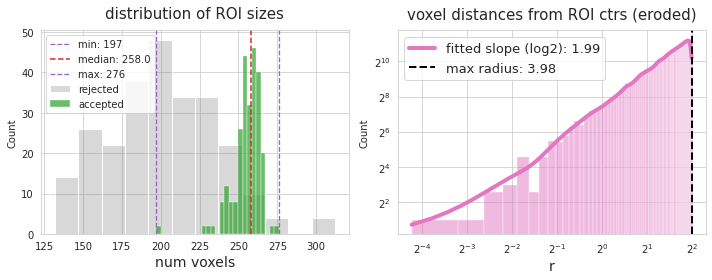

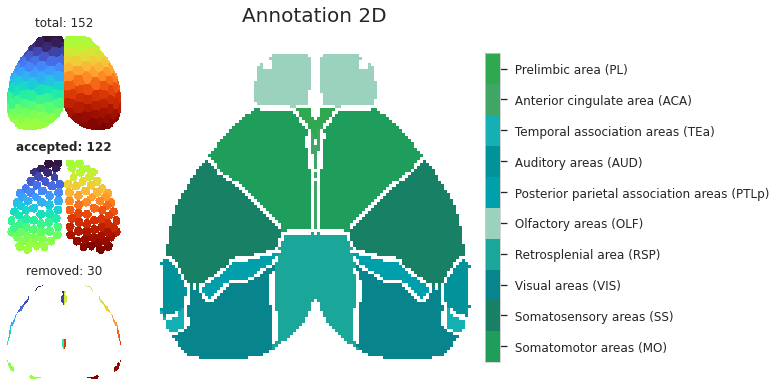

In [5]:
_ = mice.parcel.show()
_ = mice.parcel.show2d()

In [12]:
_ = parcel2html(mice.parcel.results['eroded_masks'], extras_dir, cmap='turbo')

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/parcel-256_cmap-turbo.html

In [13]:
_ = parcel2html(
    {k: v for k, v
     in mice.parcel.results['eroded_masks'].items()
     if k in [110, 238]
    },
    extras_dir,
    'interesting_nodes',
    'turbo',
)

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/interesting_nodes_parcel-2_cmap-turbo.html

## SVINET

In [376]:
mice = Mice(Config(1024))
mice.combine_dfs('rest')

key = 'sub-SLC'
metric = 'spearman'
mode = 'bold'
net = Network(
    mice=mice,
    key=key,
    metric=metric,
    mode=mode,
    binarize=False,
).fit()

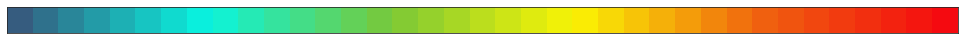

In [377]:
display_cmap(net.style['cmap'])

In [364]:
# _ = net.fig_within_hemis(tmp_dir, linewidths=0., figsize=(30, 28))
# _ = net.fig_between_hemis(tmp_dir, linewidths=0., figsize=(36, 28))

### Save Graphs

In [378]:
from analysis.network_helpers import save_edgelist, load_svinet

In [387]:
perc = 0.25
graphs = {
    f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_p-{perc}": net.graphs[perc],
    f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_cfg_p-{perc}": net.graphs_cfg[perc],
}

In [388]:
for name, g in graphs.items():
    save_dir = pjoin(svinet_ws, name)
    os.makedirs(save_dir, exist_ok=True)
    save_edgelist(g, name=name, save_dir=save_dir)

### Load results

In [8]:
def get_filter_fn(num_comm, sampling=''):
    keywords = [f"k{num_comm}", sampling]
    def filter_fn(x):
        return all(k in x for k in keywords)
    return filter_fn

def _sort_fn(x):
    return next(
        int(e.replace('seed', '').strip())
        for e in x.split('-') if 'seed' in e
    )

In [9]:
num_comm = 5
sampling = 'linksampling'

In [10]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if 'cfg' in 'name':
        continue
    name = f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_p-15"
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/10000 [00:00<?, ?it/s]

Warning, name: bold_spearman_sub-SLC_n256_p-15
bad fit: n266-k5-mmsb-seed4166-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n256_p-15
bad fit: n266-k5-mmsb-seed4943-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n256_p-15
bad fit: n266-k5-mmsb-seed9008-linksampling, # communities: 4

  0%|          | 0/10000 [00:00<?, ?it/s]

Warning, name: bold_spearman_sub-SLC_n256_p-15
bad fit: n266-k5-mmsb-seed4166-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n256_p-15
bad fit: n266-k5-mmsb-seed4943-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n256_p-15
bad fit: n266-k5-mmsb-seed9008-linksampling, # communities: 4

In [12]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n256_p-15': 9997}

In [13]:
perc = 15
run = list(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].values())[51]

community = {
    i + 1: [net.node_labels[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.node_labels[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [14]:
run['num_overlap']

185

In [15]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.node_labels), len(set(included_nodes)), num_overlap_nodes

(266, 266, 185)

In [16]:
[region for i, region in net.node_labels.items() if i not in set(included_nodes)]

[]

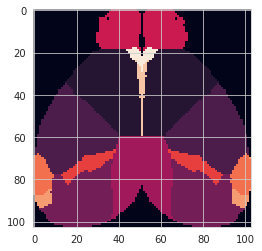

In [29]:
plt.imshow(filter_boundaries(mice.parcel.results2d['atlas']));

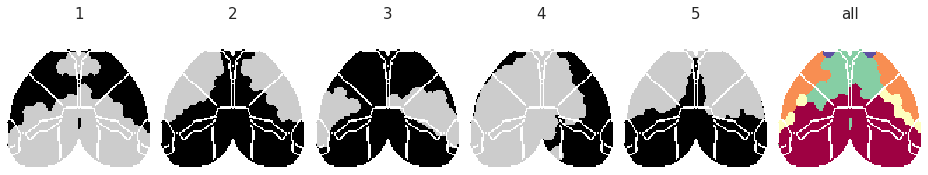

In [30]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

fig, axes = create_figure(1, num_comm + 1, (13, 3))

x2d_full = masks2cluster(masks_isocortex, mice.allen)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap='Spectral')
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2cluster({i: masks_isocortex[i]}, mice.allen)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    ax.imshow(data2plt, cmap='nipy_spectral')
    ax.set_title(i, fontsize=15)

remove_ticks(axes)
plt.show()

In [31]:
_ = parcel2html(
    masks=masks_isocortex,
    save_dir=extras_dir,
    save_name='SVINET-cortex',
    cmap=sns.color_palette("tab10", as_cmap=True),
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET-cortex_parcel-5_cmap-tab10.html

### Align communities
#### Use k means
#### Use clusters_sim_scores
#### Use cortex mask only to find scores (weighted stuff)
#### Subcortical areas are too big, they might corrupt the results

In [16]:
prototypes = []
for run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].values():
    comm_vec = {
        i + 1: np.reshape([1 if i in v else 0 for i in net.node_labels], (1, -1))
        for i, v in run['community'].items()
    }
    prototypes.extend(list(comm_vec.values()))
prototypes = np.concatenate(prototypes)

In [17]:
prototypes.shape

(5000, 266)

<matplotlib.image.AxesImage object at 0x7f3a68c44fd0>

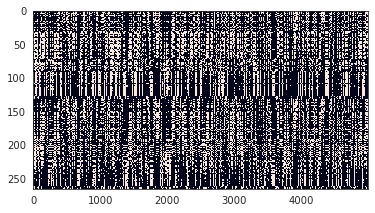

In [18]:
plt.imshow(prototypes.T, aspect=10)

In [19]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [20]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

In [21]:
end-start

0.4711029529571533

In [22]:
model.cluster_centers_.shape

(5, 266)

[
    <matplotlib.lines.Line2D object at 0x7f3a50bcbc70>,
    <matplotlib.lines.Line2D object at 0x7f3a50bcbca0>,
    <matplotlib.lines.Line2D object at 0x7f3a50bcbe20>,
    <matplotlib.lines.Line2D object at 0x7f3a50bcbee0>,
    <matplotlib.lines.Line2D object at 0x7f3a50bcbfa0>
]

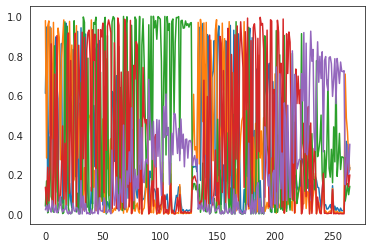

In [23]:
plt.plot(model.cluster_centers_.T)

<AxesSubplot:ylabel='Count'>

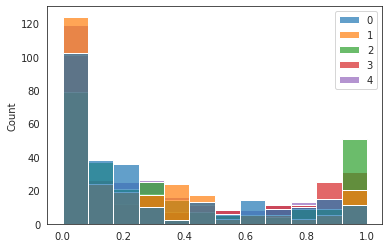

In [24]:
sns.histplot(model.cluster_centers_.T, alpha=0.7)

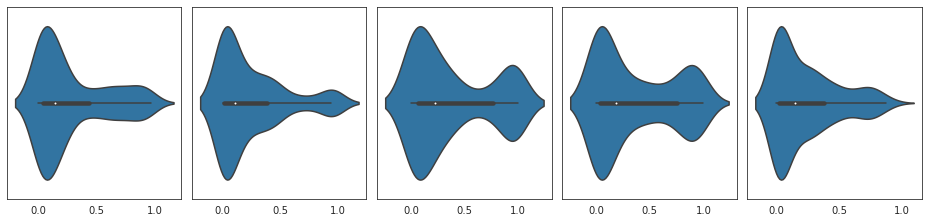

In [26]:
fig, axes = create_figure(1, num_comm, (13, 3.2))

for i in range(num_comm):
    sns.violinplot(model.cluster_centers_[i], ax=axes[i])
plt.show()

[<matplotlib.lines.Line2D object at 0x7f3a2c146850>]

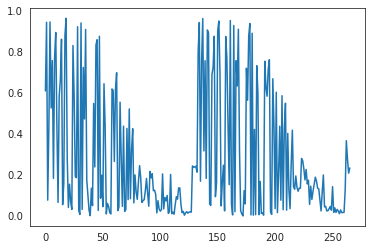

In [27]:
oc = 0
oc_center = model.cluster_centers_[oc]

plt.plot(oc_center)

In [178]:
vec_canonical = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.node_labels.items()
    } for i in range(num_comm)
}
vols_canonical = vec2vol(vec_canonical, mice)
vols_canonical.keys()

dict_keys([1, 2, 3, 4, 5])

<matplotlib.image.AxesImage object at 0x7f3a2c18c760>

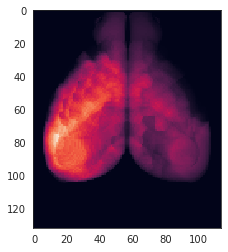

In [179]:
plt.imshow(vols_canonical[3].mean(1))

In [261]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in qs:
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in vols_canonical.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

<matplotlib.lines.Line2D object at 0x7f39806e5730>

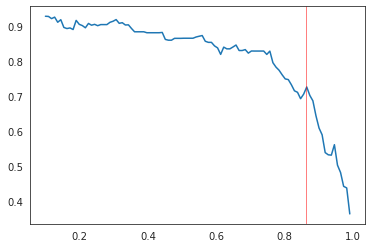

In [262]:
plt.plot(qs, sym_scores)
plt.axvline(0.863, color='r', lw=0.5)

In [263]:
q = 0.863
comms_quant = {i: v > np.quantile(v[v > 0], q) for i, v in vols_canonical.items()}

<matplotlib.image.AxesImage object at 0x7f39804ba2b0>

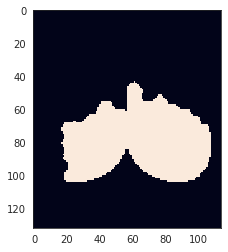

In [264]:
ii = 5
x3d, x2d = masks2cluster({ii: comms_quant[ii]}, mice.allen)
plt.imshow(x2d)

<matplotlib.image.AxesImage object at 0x7f3980402eb0>

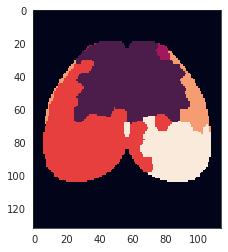

In [265]:
x3d, x2d = masks2cluster(comms_quant, mice.allen)
plt.imshow(x2d)

<matplotlib.lines.Line2D object at 0x7f39806a84f0>

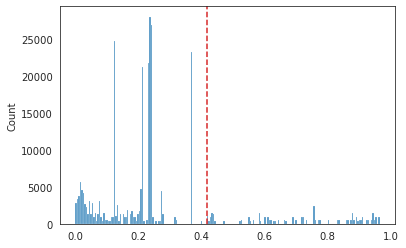

In [266]:
v = vols_canonical[1].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')

In [267]:
comms_quant[1].shape

(132, 80, 114)

In [268]:
q = 0.863
comms_quant = {i: v > np.quantile(v[v > 0], q) for i, v in vols_canonical.items()}

comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}

In [269]:
comm_vec_quant[1].shape

(1, 266)

In [270]:
model.cluster_centers_[0].shape

(266,)

In [275]:
centers_quant = np.concatenate(list(comm_vec_quant.values()))
qs = np.linspace(0.5, 0.9, 100)
hamming_scores = []
for sig_q in qs:
    hamming_dist = sp_dist.cdist(
        centers_quant,
        sigmoid(model.cluster_centers_) > sig_q,
        metric='hamming',
    )
    hamming_score = 1 - hamming_dist
    hamming_scores.append(np.mean(np.diag(hamming_score)))

<matplotlib.lines.Line2D object at 0x7f396fd90af0>

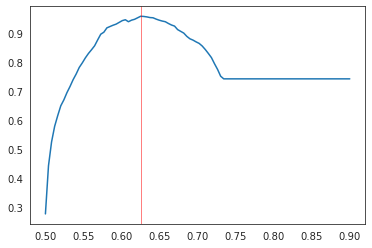

In [276]:
plt.plot(qs, hamming_scores)
plt.axvline(0.625, color='r', lw=0.5)

In [277]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

[<matplotlib.lines.Line2D object at 0x7f396fc217f0>]

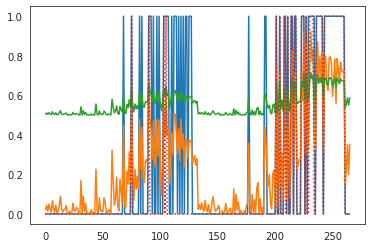

In [278]:
i = 5
plt.plot(comm_vec_quant[i].ravel())
plt.plot(model.cluster_centers_[i - 1])
plt.plot(sigmoid(model.cluster_centers_[i - 1]))
plt.plot(sigmoid(model.cluster_centers_[i - 1]) > 0.625, ls=':')

In [279]:
(sigmoid(model.cluster_centers_[i - 1]) > 0.625).sum()

44

In [280]:
(model.cluster_centers_[i - 1] > 0).sum()

259

In [259]:
comm_vec_quant[i].ravel().sum()

73.0

In [287]:
qs = np.linspace(0.4, 1.0, 100)
sym_scores = []
for q in tqdm(qs):
    centers_sigmoid = {
        i + 1: {
            region: sigmoid(model.cluster_centers_[i, n])
            for n, region in net.node_labels.items()
        } for i in range(num_comm)
    }
    vols_sigmoid = vec2vol(centers_sigmoid, mice)
    comms_quant = {
        i: v > q
        for i, v in vols_sigmoid.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f38fa93a2e0>

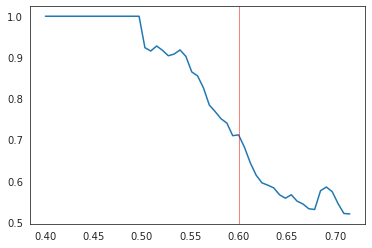

In [348]:
plt.plot(qs, sym_scores)
plt.axvline(0.60, color='r', lw=0.5)

In [351]:
q = 0.863
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in vols_canonical.items()
}

comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

In [352]:
vec_sigmoid = {
    i + 1: {
        region: sigmoid(model.cluster_centers_[i, n])
        for n, region in net.node_labels.items()
    } for i in range(num_comm)
}
vols_sigmoid = vec2vol(vec_sigmoid, mice)

g_sig = 0.600
comms_quant_sig = {
    i: v > g_sig
    for i, v in vols_sigmoid.items()
}
comm_vec_quant_sig = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant_sig.items()
}
centers_quant_sig = np.concatenate(list(comm_vec_quant_sig.values()))

In [353]:
dice_dist = sp_dist.cdist(
    centers_quant,
    centers_quant_sig,
    metric='dice',
)
dice_score = 1 - dice_dist

hamming_dist = sp_dist.cdist(
    centers_quant,
    centers_quant_sig,
    metric='dice',
)
hamming_score = 1 - hamming_dist

<matplotlib.colorbar.Colorbar object at 0x7f38fa599520>

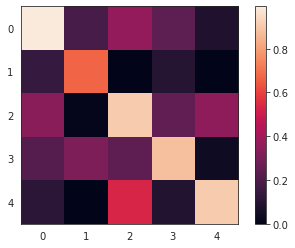

In [354]:
plt.imshow(dice_score)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f38fa4a50a0>

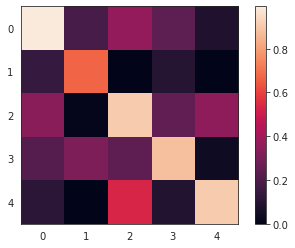

In [355]:
plt.imshow(hamming_score)
plt.colorbar()

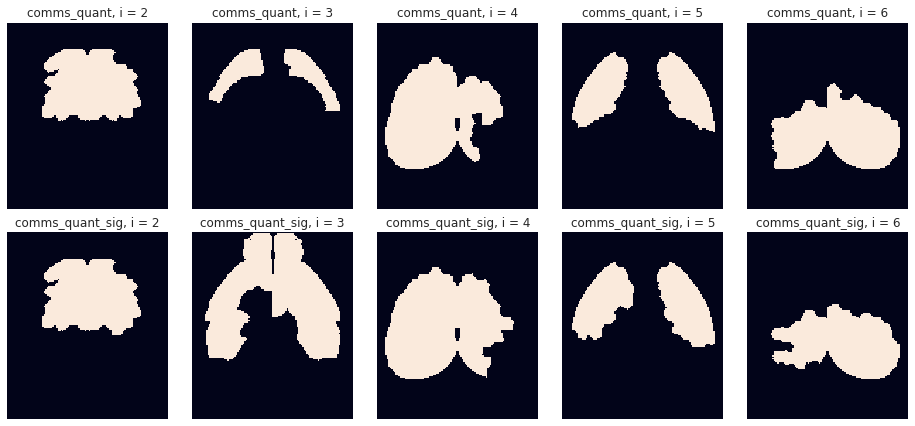

In [360]:
fig, axes = create_figure(2, num_comm, (13, 6))

for ii in range(1, num_comm + 1):
    x2d = masks2cluster({ii: comms_quant[ii]}, mice.allen)[-1]
    axes[0, ii - 1].imshow(x2d)
    axes[0, ii - 1].set_title(f"comms_quant, i = {ii+1}")
    
for ii in range(1, num_comm + 1):
    x2d = masks2cluster({ii: comms_quant_sig[ii]}, mice.allen)[-1]
    axes[1, ii - 1].imshow(x2d)
    axes[1, ii - 1].set_title(f"comms_quant_sig, i = {ii+1}")
    
remove_ticks(axes)

In [393]:
centers = dc(model.cluster_centers_)

metrics = {
    'cosine': float,
    'correlation': float,
    'dice': bool,
    'hamming': bool,
}

dict_list = []
perms = {}
for run_name, run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items():
    comm_vec = {
        i + 1: np.reshape([1 if i in v else 0 for i in net.node_labels], (1, -1))
        for i, v in run['community'].items()
    }
    oc_moving = np.concatenate(list(comm_vec.values()))

    dists = {
        k: sp_dist.cdist(
            XA=centers.astype(d) if d is float
            else centers_quant_sig.astype(d),
            XB=oc_moving.astype(d),
            metric=k,
        ) for k, d in metrics.items()
    }
    scores = {
        k: 1 - d
        for k, d in dists.items()
    }

    mapping = find_best_match(scores['hamming'])
    perms[run_name] = mapping
    
    cosine_sim = cosine_sim[:, list(mapping.values())]
    dice_sim = dice_sim[:, list(mapping.values())]

    for k, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [k] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

(0.0, 1.0)

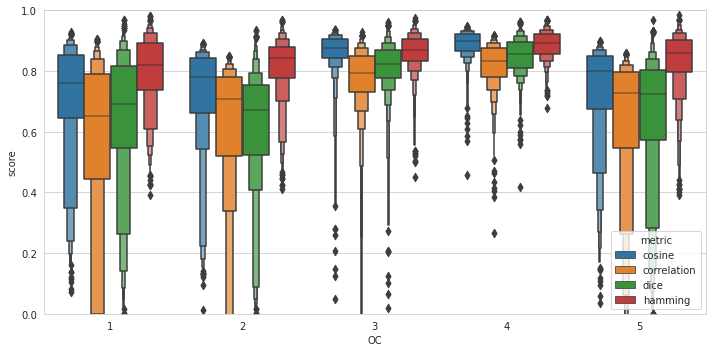

In [394]:
fig, ax = create_figure(1, 1, (10, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)

<matplotlib.legend.Legend object at 0x7f38f85e6a60>

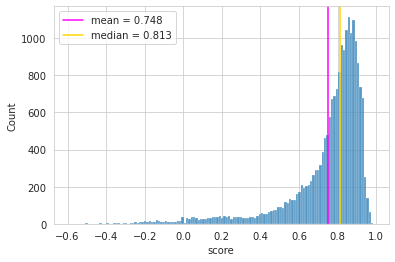

In [408]:
sns.histplot(data=results, x='score')
_mean = results.score.mean()
_median = results.score.median()
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend()

In [409]:
oc_aligned = {}
for run_name, run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items():
    comm_vec = {
        i + 1: np.reshape([1 if i in v else 0 for i in net.node_labels], (1, -1))
        for i, v in run['community'].items()
    }
    oc_moving = np.concatenate(list(comm_vec.values()))

    mapping = perms[run_name]
    oc_aligned[run_name] = oc_moving[list(mapping.values())]

In [410]:
dict_list = []
for run_name in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [411]:
oc_flat_df.shape

(1330000, 5)

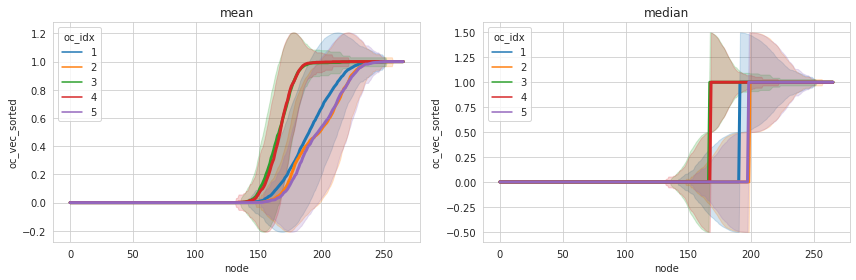

In [412]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=3,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
plt.show()

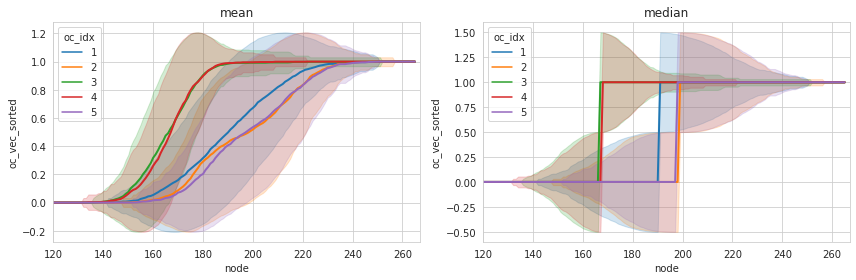

In [413]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(120, len(net.node_labels) + 1)
plt.show()

In [455]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items()):
    if run_id > 10:
        break
    mapping = perms[run_name]       
    community = {
        i + 1: [net.node_labels[e] for e in comm_list]
        for i, comm_list in run['community'].items()
    }
    community = dict(zip(
        community.keys(),
        np.array(list(community.values()))[list(mapping.values())]
    ))
    masks = community2masks(community, mice)
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in masks.items()
    }
    masks_aligned[run_name] = masks_cortex

In [456]:
mapping

{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}

In [457]:
community.keys()

dict_keys([1, 2, 3, 4, 5])

In [458]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

x2d_full_can = masks2cluster(comms_quant_sig, mice.allen)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

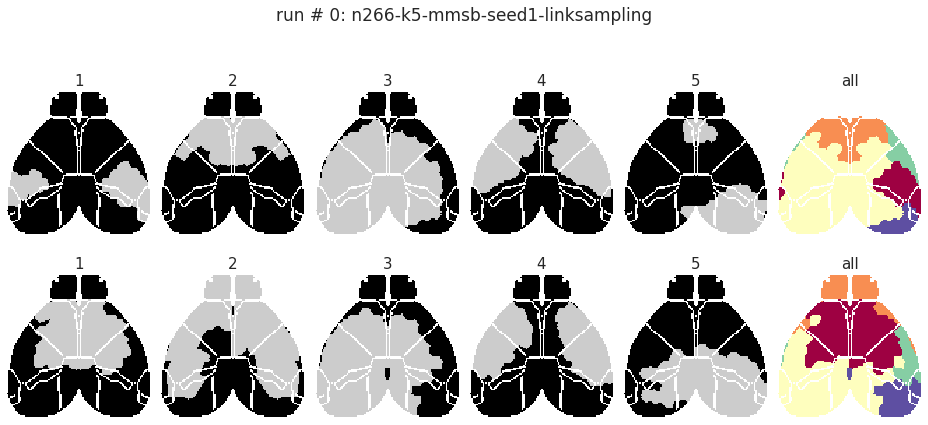

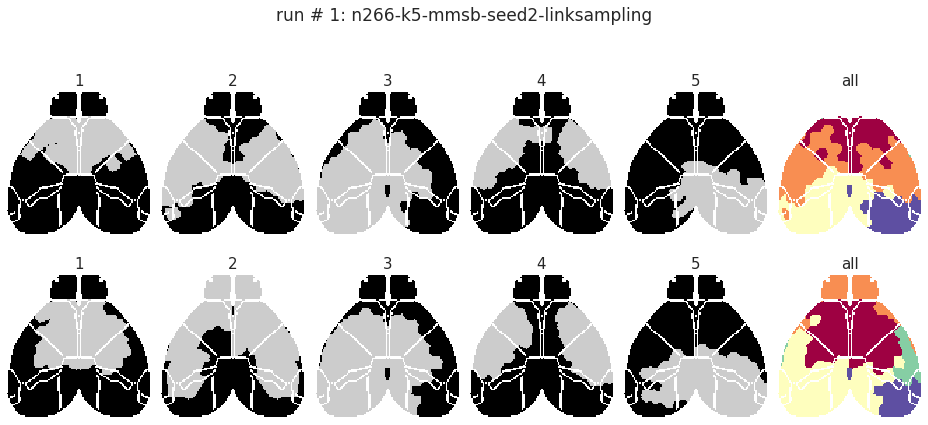

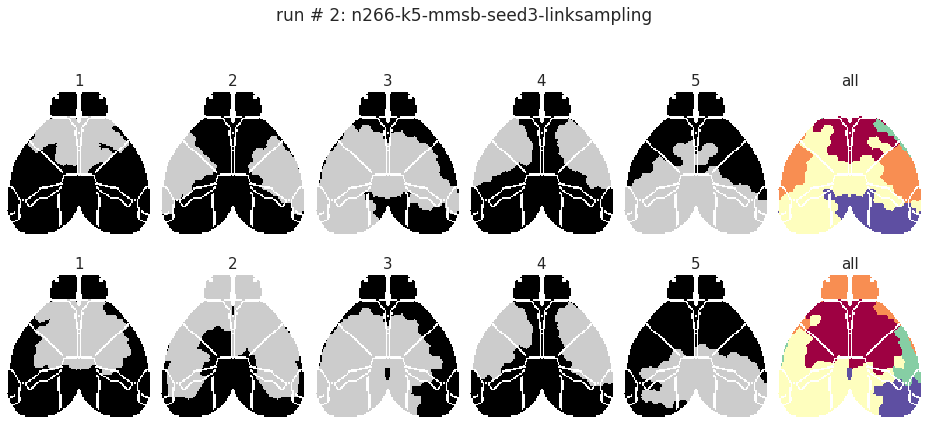

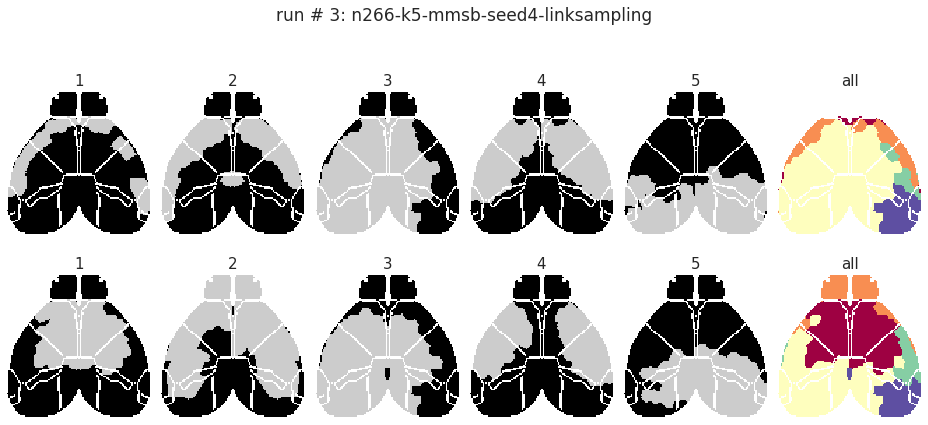

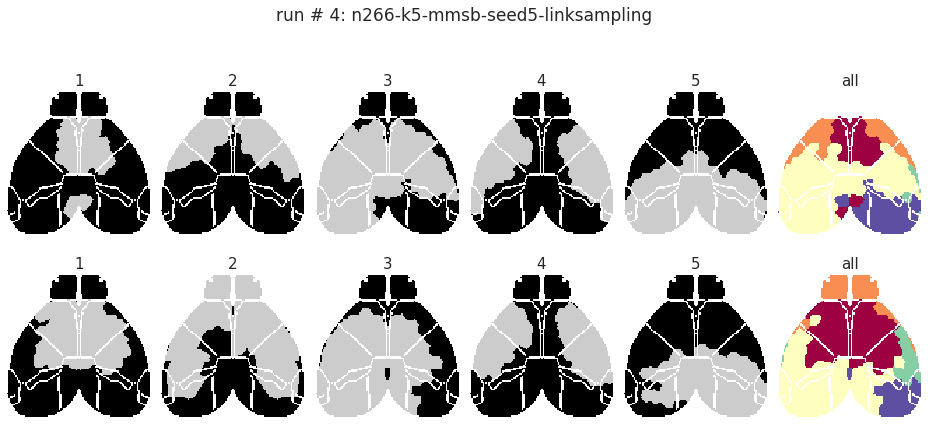

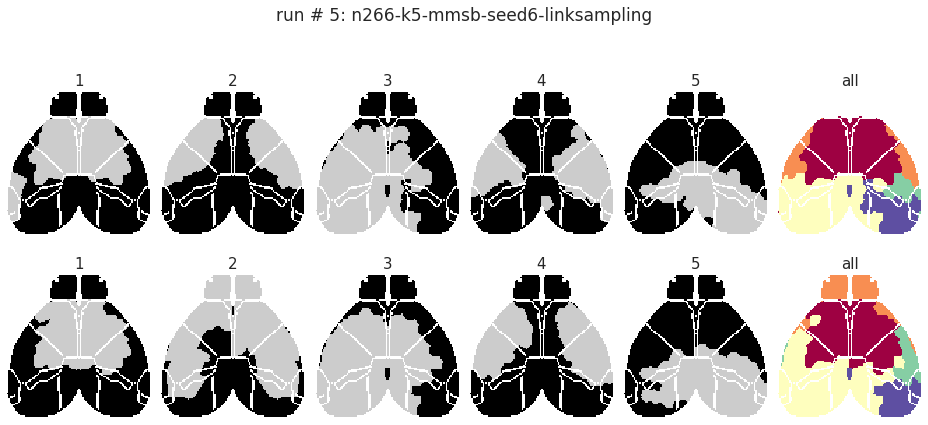

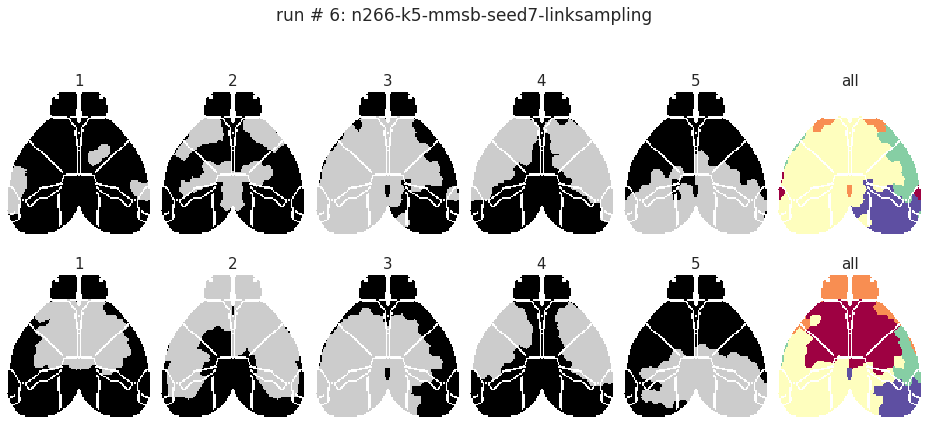

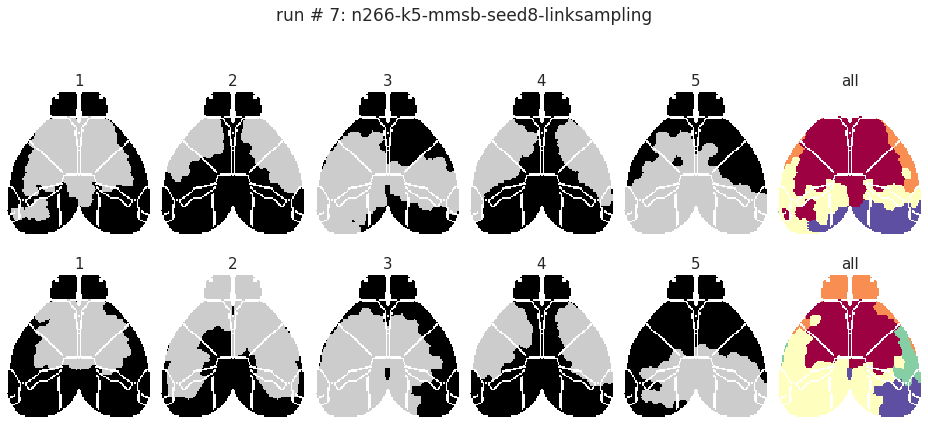

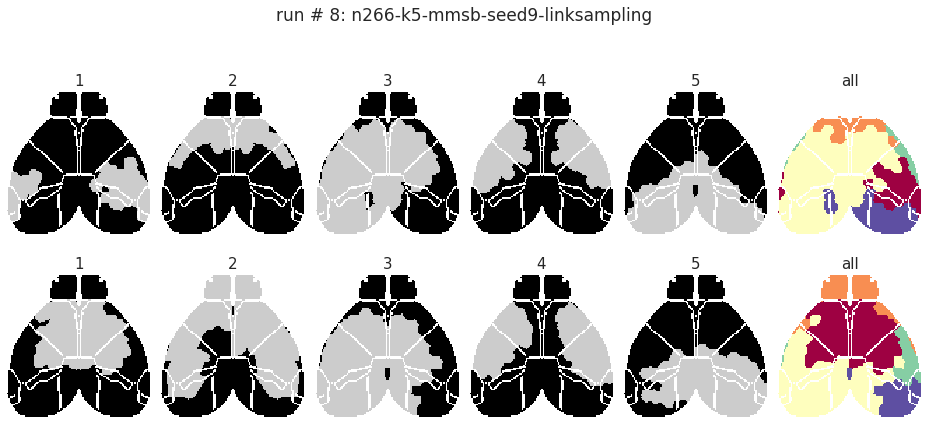

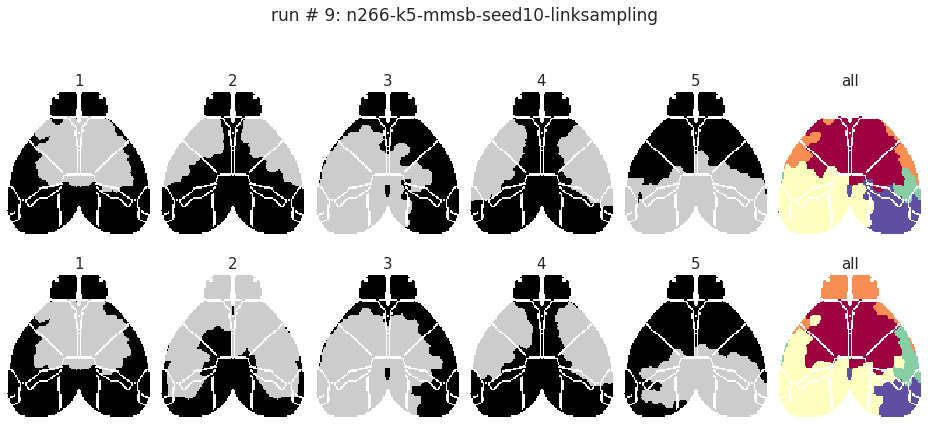

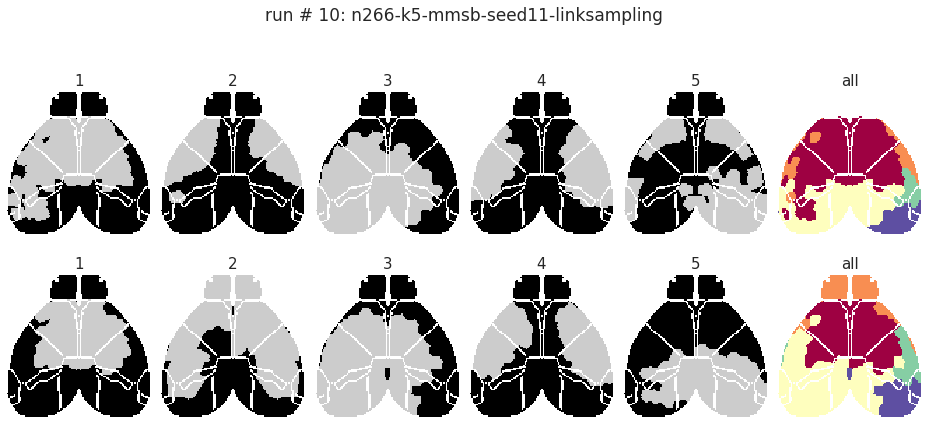

In [459]:
for run_id, (run_name, run) in enumerate(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items()):
    if run_id > 10:
        break
        
    community = {
        i + 1: [net.node_labels[e] for e in comm_list]
        for i, comm_list in run['community'].items()
    }
    masks = community2masks(community, mice)
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in masks.items()
    }
    
    fig, axes = create_figure(2, num_comm + 1, (13, 6))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: masks_aligned[run_name][i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant_sig[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

In [ ]:
pi_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items()):
    if run_id > 10:
        break
    mapping = perms[run_name]       

    masks_aligned[run_name] = masks_cortex

In [465]:
pi = np.concatenate([x.reshape(1, -1) for x in run['membership'].values()])
pi.shape

(266, 5)

[
    <matplotlib.lines.Line2D object at 0x7f38f5b3ed00>,
    <matplotlib.lines.Line2D object at 0x7f38f5a06760>,
    <matplotlib.lines.Line2D object at 0x7f38f5a06c10>,
    <matplotlib.lines.Line2D object at 0x7f38f5a06eb0>,
    <matplotlib.lines.Line2D object at 0x7f38f5a067c0>
]

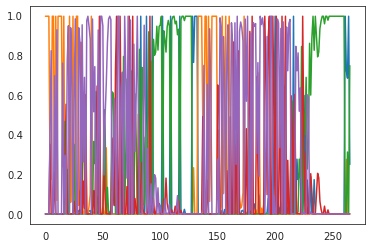

In [466]:
plt.plot(pi)

### Align using memship vectors

In [37]:
prototypes = []
for run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [38]:
prototypes.shape

(49985, 266)

<matplotlib.colorbar.Colorbar object at 0x7f97b15c6a30>

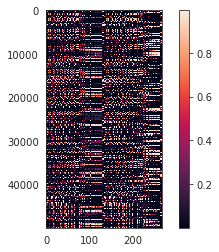

In [39]:
plt.imshow(prototypes, aspect=0.01)
plt.colorbar()

In [40]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [41]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

In [43]:
delta

'00 - 00:00:07  (dd - hh:mm:ss)\n'

In [44]:
model.cluster_centers_.shape

(5, 266)

[
    <matplotlib.lines.Line2D object at 0x7f97b143adc0>,
    <matplotlib.lines.Line2D object at 0x7f97b143af10>,
    <matplotlib.lines.Line2D object at 0x7f97b143d040>,
    <matplotlib.lines.Line2D object at 0x7f97b143d160>,
    <matplotlib.lines.Line2D object at 0x7f97b143d280>
]

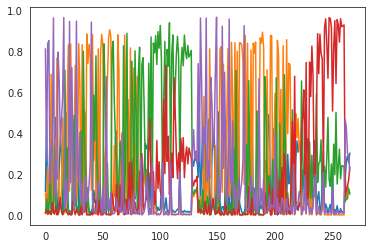

In [45]:
plt.plot(model.cluster_centers_.T)

<AxesSubplot:ylabel='Count'>

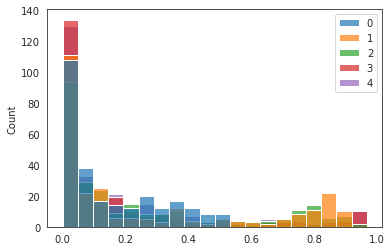

In [46]:
sns.histplot(model.cluster_centers_.T, alpha=0.7)

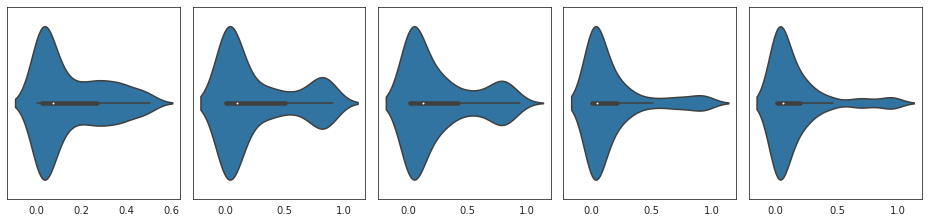

In [47]:
fig, axes = create_figure(1, num_comm, (13, 3.2))

for i in range(num_comm):
    sns.violinplot(model.cluster_centers_[i], ax=axes[i])
plt.show()

[<matplotlib.lines.Line2D object at 0x7f97b00f4ee0>]

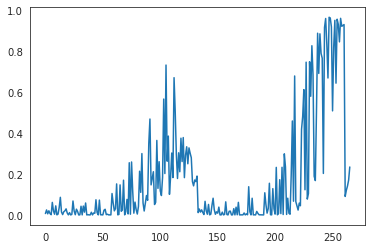

In [54]:
oc = 3
oc_center = model.cluster_centers_[oc]

plt.plot(oc_center)

In [55]:
memship_vec_can = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.node_labels.items()
    } for i in range(num_comm)
}
memship_vol_can = vec2vol(memship_vec_can, mice)
memship_vol_can.keys()

dict_keys([1, 2, 3, 4, 5])

In [106]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in qs:
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol_can.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

<matplotlib.lines.Line2D object at 0x7f9702b7cd30>

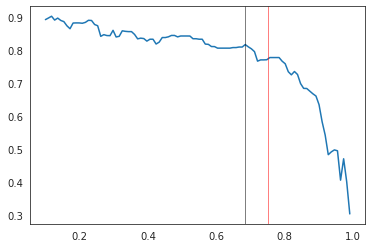

In [119]:
plt.plot(qs, sym_scores)
plt.axvline(0.75, color='r', lw=0.5)
plt.axvline(0.683, color='k', lw=0.5)

In [124]:
q = 0.683
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}

<matplotlib.image.AxesImage object at 0x7f97029d0280>

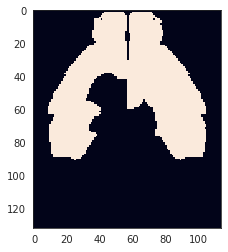

In [125]:
ii = 5
x3d, x2d = masks2cluster({ii: comms_quant[ii]}, mice.allen)
plt.imshow(x2d)

<matplotlib.image.AxesImage object at 0x7f9702b928e0>

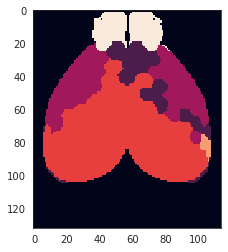

In [126]:
x3d, x2d = masks2cluster(comms_quant, mice.allen)
plt.imshow(x2d)

<matplotlib.lines.Line2D object at 0x7f9702d28850>

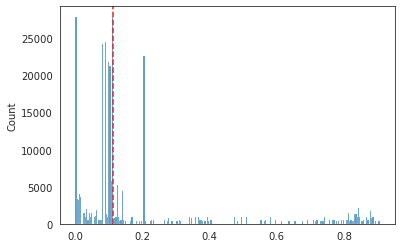

In [127]:
v = memship_vol_can[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')

In [128]:
comms_quant[1].shape

(132, 80, 114)

In [129]:
q = 0.683
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}

In [131]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [132]:
centers_quant = np.concatenate(list(comm_vec_quant.values()))
qs = np.linspace(0.5, 0.9, 100)
hamming_scores = []
for sig_q in qs:
    hamming_dist = sp_dist.cdist(
        centers_quant,
        sigmoid(model.cluster_centers_) > sig_q,
        metric='hamming',
    )
    hamming_score = 1 - hamming_dist
    hamming_scores.append(np.mean(np.diag(hamming_score)))

<matplotlib.lines.Line2D object at 0x7f9702e61dc0>

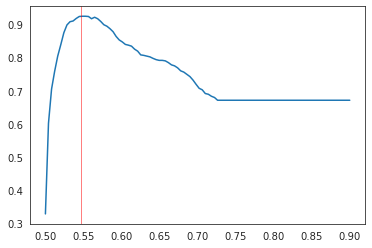

In [133]:
plt.plot(qs, hamming_scores)
plt.axvline(0.547, color='r', lw=0.5)

[<matplotlib.lines.Line2D object at 0x7f9702cfe190>]

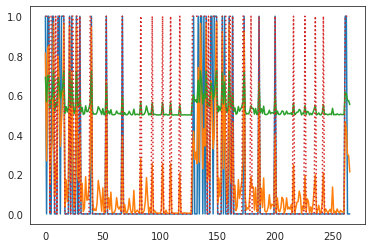

In [134]:
i = 5
plt.plot(comm_vec_quant[i].ravel())
plt.plot(model.cluster_centers_[i - 1])
plt.plot(sigmoid(model.cluster_centers_[i - 1]))
plt.plot(sigmoid(model.cluster_centers_[i - 1]) > 0.547, ls=':')

In [135]:
(sigmoid(model.cluster_centers_[i - 1]) > 0.547).sum()

70

In [136]:
(model.cluster_centers_[i - 1] > 0).sum()

266

In [137]:
comm_vec_quant[i].ravel().sum()

37.0

In [138]:
qs = np.linspace(0.4, 1.0, 100)
sym_scores = []
for q in tqdm(qs):
    centers_sigmoid = {
        i + 1: {
            region: sigmoid(model.cluster_centers_[i, n])
            for n, region in net.node_labels.items()
        } for i in range(num_comm)
    }
    vols_sigmoid = vec2vol(centers_sigmoid, mice)
    comms_quant = {
        i: v > q
        for i, v in vols_sigmoid.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f970298aca0>

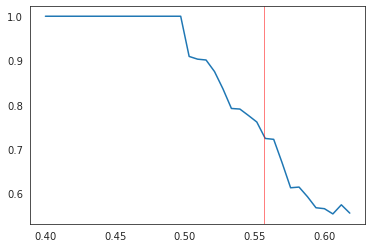

In [139]:
plt.plot(qs, sym_scores)
plt.axvline(0.557, color='r', lw=0.5)

In [141]:
q = 0.674
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

In [142]:
vec_sigmoid = {
    i + 1: {
        region: sigmoid(model.cluster_centers_[i, n])
        for n, region in net.node_labels.items()
    } for i in range(num_comm)
}
vols_sigmoid = vec2vol(vec_sigmoid, mice)

g_sig = 0.557
comms_quant_sig = {
    i: v > g_sig
    for i, v in vols_sigmoid.items()
}
comm_vec_quant_sig = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant_sig.items()
}
centers_quant_sig = np.concatenate(list(comm_vec_quant_sig.values()))

In [143]:
dice_dist = sp_dist.cdist(
    centers_quant,
    centers_quant_sig,
    metric='dice',
)
dice_score = 1 - dice_dist

hamming_dist = sp_dist.cdist(
    centers_quant,
    centers_quant_sig,
    metric='dice',
)
hamming_score = 1 - hamming_dist

<matplotlib.colorbar.Colorbar object at 0x7f970287b850>

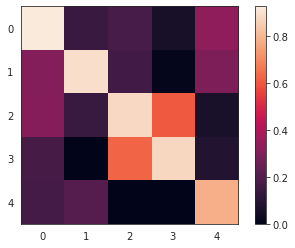

In [144]:
plt.imshow(dice_score)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f9702801f10>

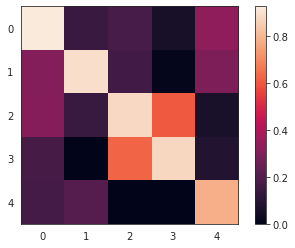

In [145]:
plt.imshow(hamming_score)
plt.colorbar()

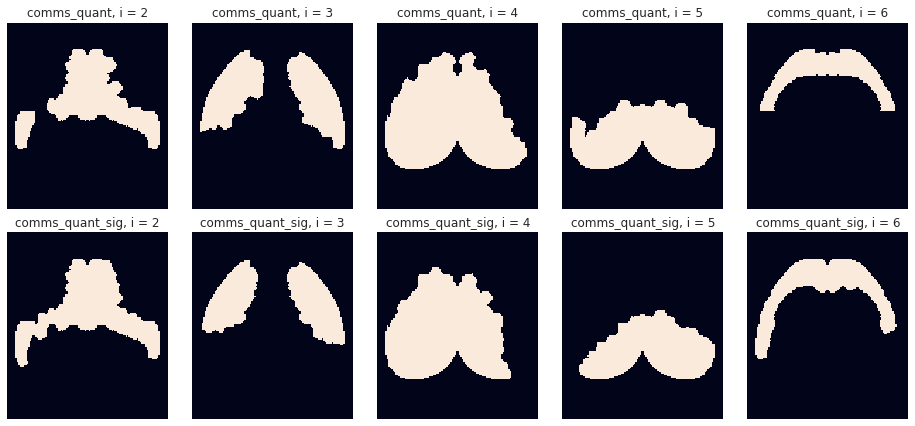

In [146]:
fig, axes = create_figure(2, num_comm, (13, 6))

for ii in range(1, num_comm + 1):
    x2d = masks2cluster({ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])}, mice.allen)[-1]
    axes[0, ii - 1].imshow(x2d)
    axes[0, ii - 1].set_title(f"comms_quant, i = {ii+1}")
    
for ii in range(1, num_comm + 1):
    x2d = masks2cluster({ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant_sig[ii])}, mice.allen)[-1]
    axes[1, ii - 1].imshow(x2d)
    axes[1, ii - 1].set_title(f"comms_quant_sig, i = {ii+1}")
    
remove_ticks(axes)

In [153]:
centers = dc(model.cluster_centers_)

metrics = {
    'cosine': float,
    'correlation': float,
    'braycurtis': float,
    'jensenshannon': float,
    'dice': bool,
    'hamming': bool,
}

dict_list = []
perms = {}
for run_name, run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(d) if d is float
            else centers_quant.astype(d),
            XB=run['pi'].astype(d),
            metric=metric,
        ) for metric, d in metrics.items()
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

(0.0, 1.0)

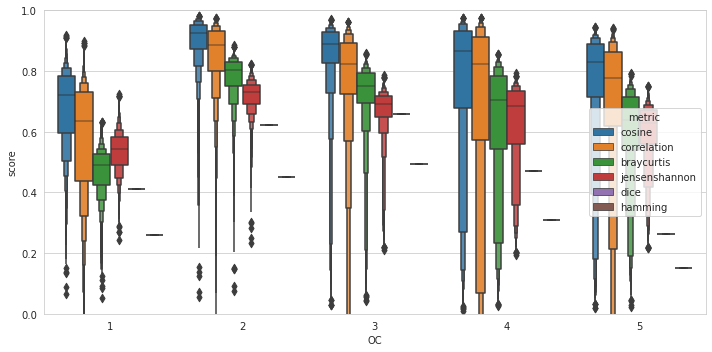

In [154]:
fig, ax = create_figure(1, 1, (10, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)

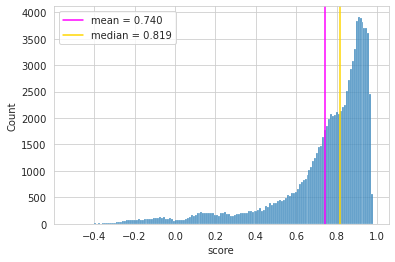

In [155]:
selected_df = results.loc[results.metric.isin(['cosine', 'correlation'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [156]:
oc_aligned = {}
for run_name, run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items():
    comm_vec = {
        i + 1: np.reshape([1 if i in v else 0 for i in net.node_labels], (1, -1))
        for i, v in run['community_sv'].items()
    }
    oc_moving = np.concatenate(list(comm_vec.values()))

    mapping = perms[run_name]
    oc_aligned[run_name] = oc_moving[list(mapping.values())]

In [157]:
dict_list = []
for run_name in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [158]:
oc_flat_df.shape

(13296010, 5)

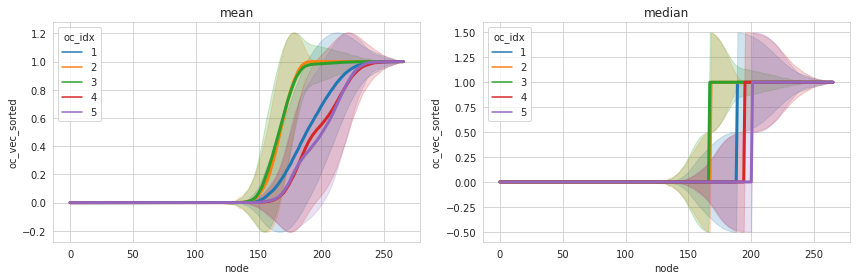

In [159]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=3,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
plt.show()

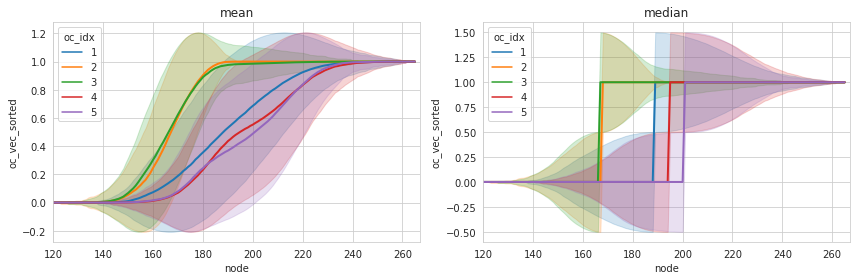

In [160]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(120, len(net.node_labels) + 1)
plt.show()

In [174]:
pi_aligned = {}
for run_name, run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items():
    mapping = perms[run_name]
    pi = run['pi'][list(mapping.values())]
    pi_aligned[run_name] = np.round(pi, 1)

In [175]:
dict_list = []
for run_name in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'pi_vec': pi_aligned[run_name][i],
            'pi_vec_sorted': sorted(pi_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

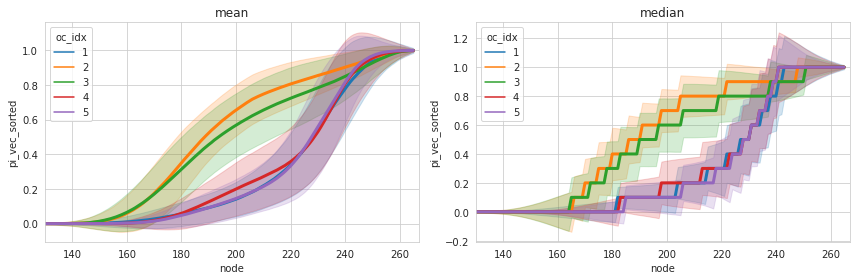

In [176]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=3,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(130, len(net.node_labels) + 1)
plt.show()

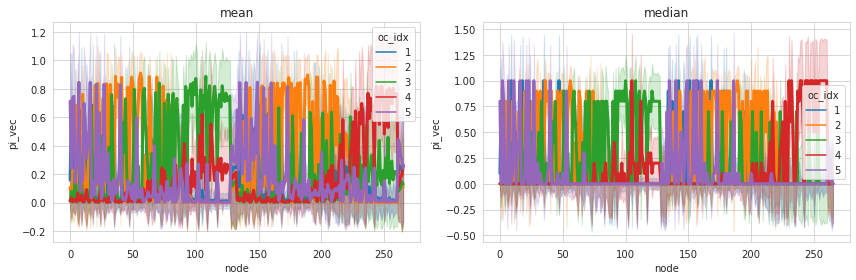

In [177]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec',
        hue='oc_idx',
        lw=3,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
plt.show()

In [169]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items()):
    if run_id > 10:
        break
    mapping = perms[run_name]       
    community = {
        i + 1: [net.node_labels[e] for e in comm_list]
        for i, comm_list in run['community_sv'].items()
    }
    community = dict(zip(
        community.keys(),
        np.array(list(community.values()))[list(mapping.values())]
    ))
    masks = community2masks(community, mice)
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in masks.items()
    }
    masks_aligned[run_name] = masks_cortex

In [170]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2cluster(comms_quant, mice.allen)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

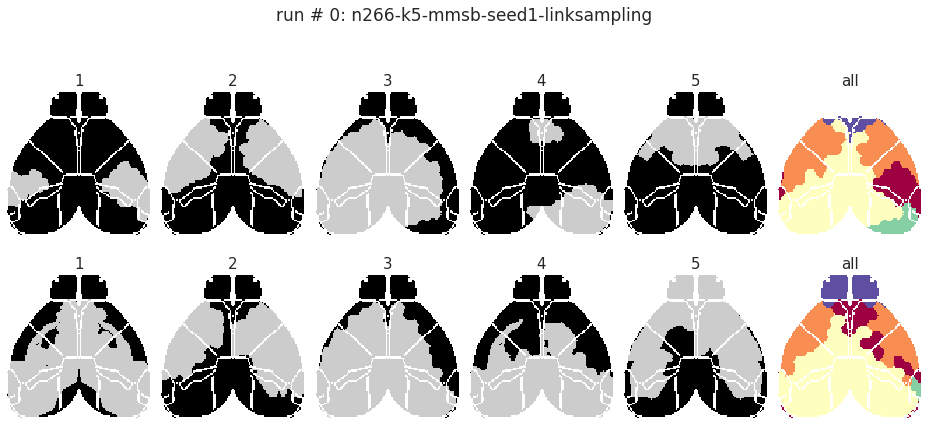

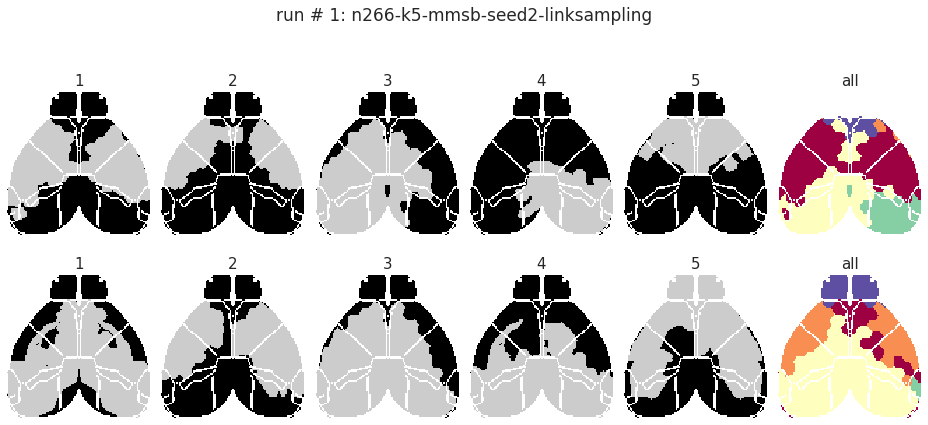

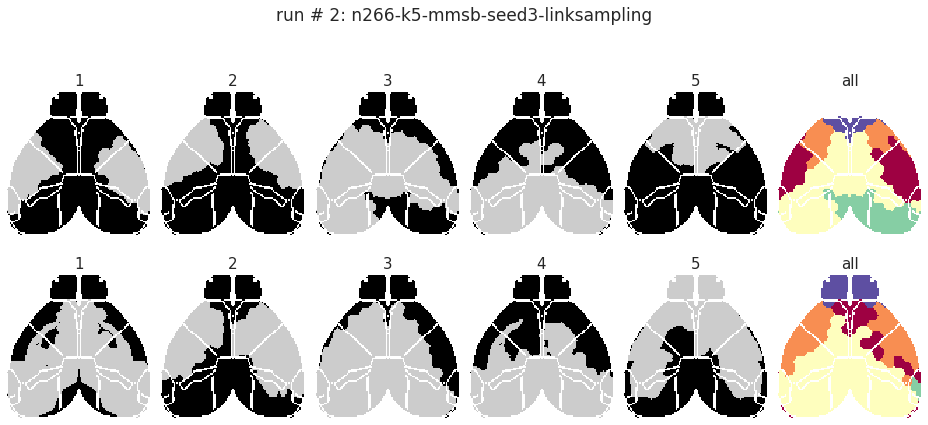

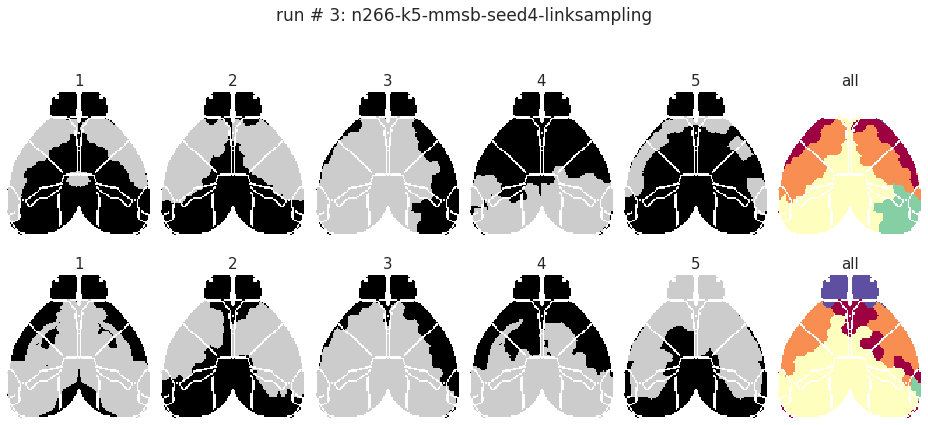

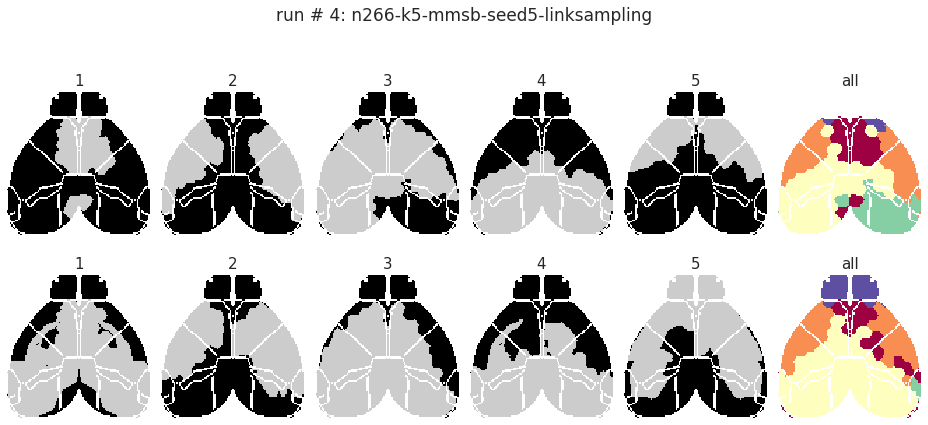

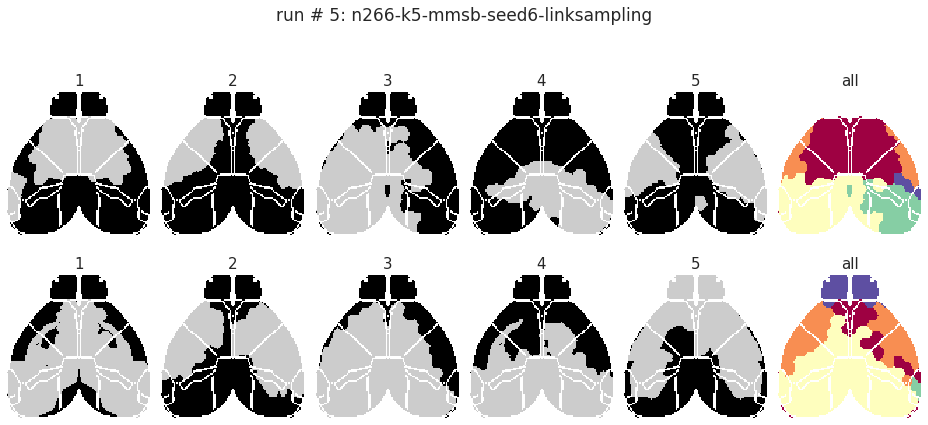

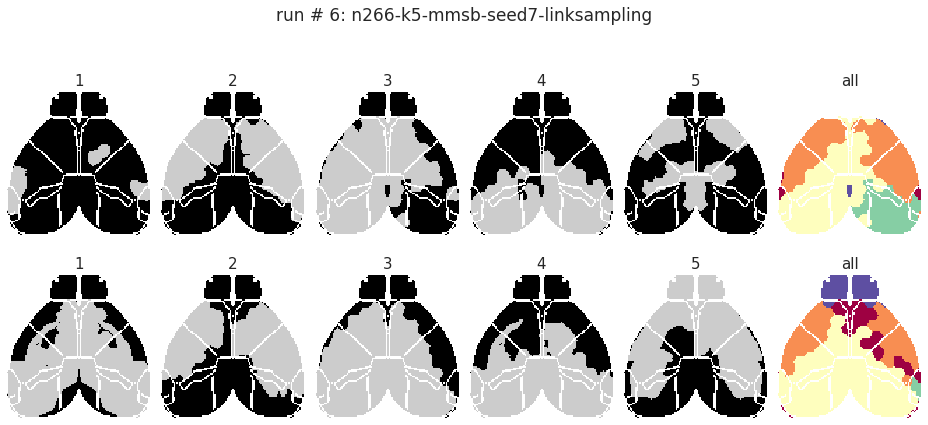

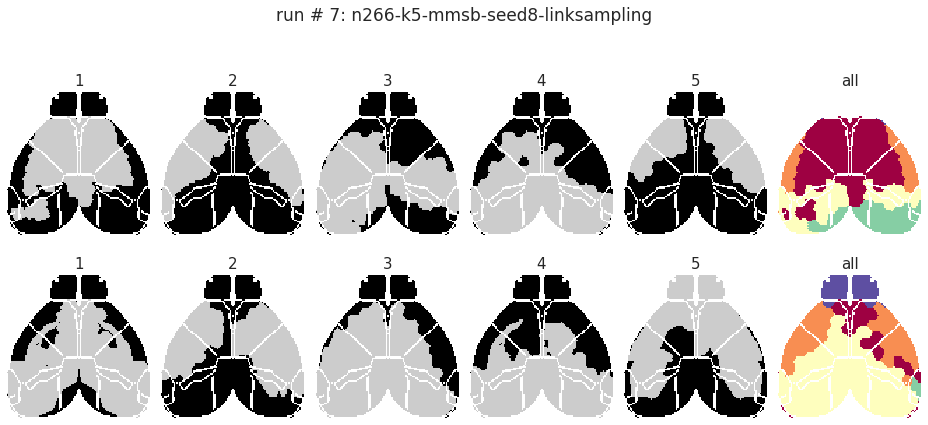

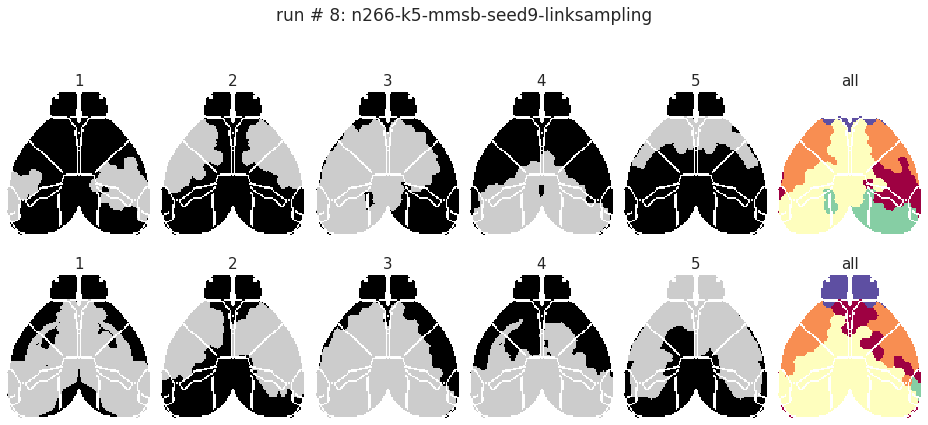

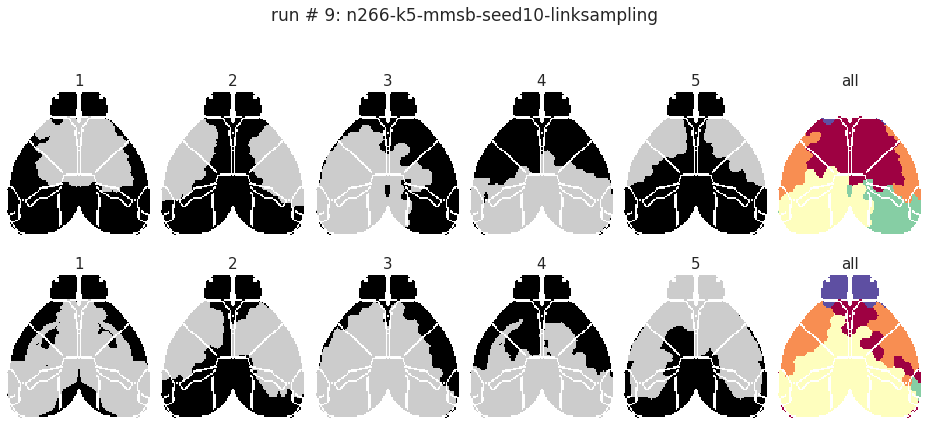

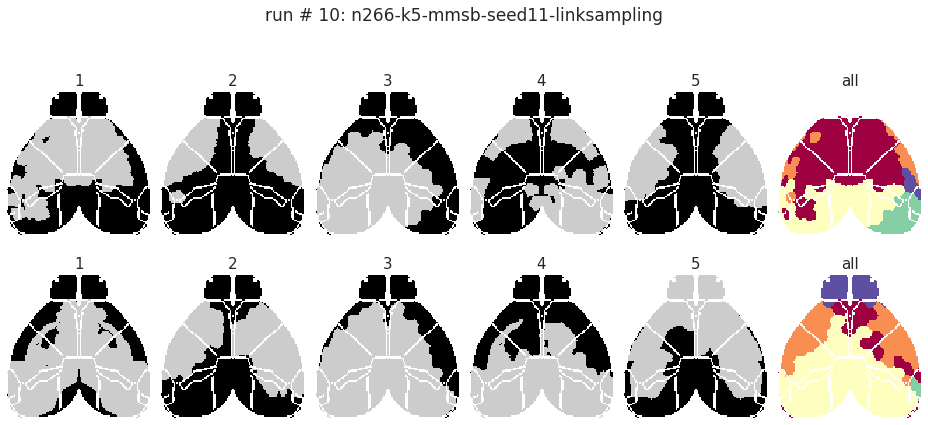

In [172]:
for run_id, (run_name, run) in enumerate(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items()):
    if run_id > 10:
        break
    
    fig, axes = create_figure(2, num_comm + 1, (13, 6))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: masks_aligned[run_name][i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

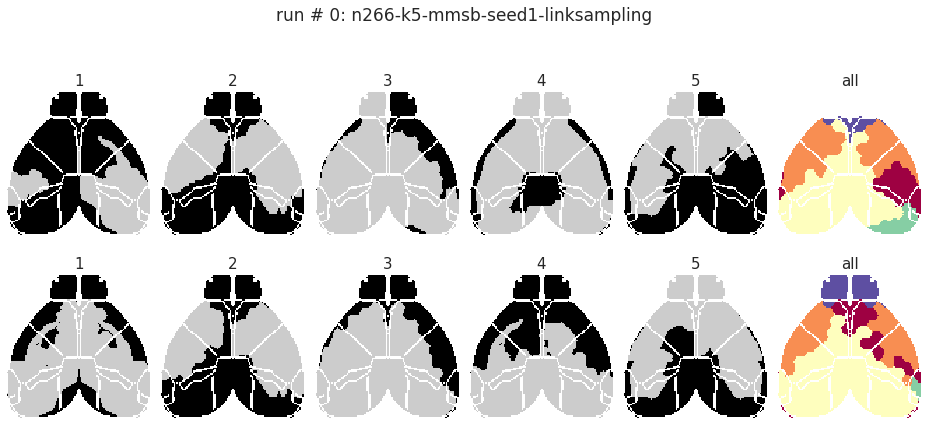

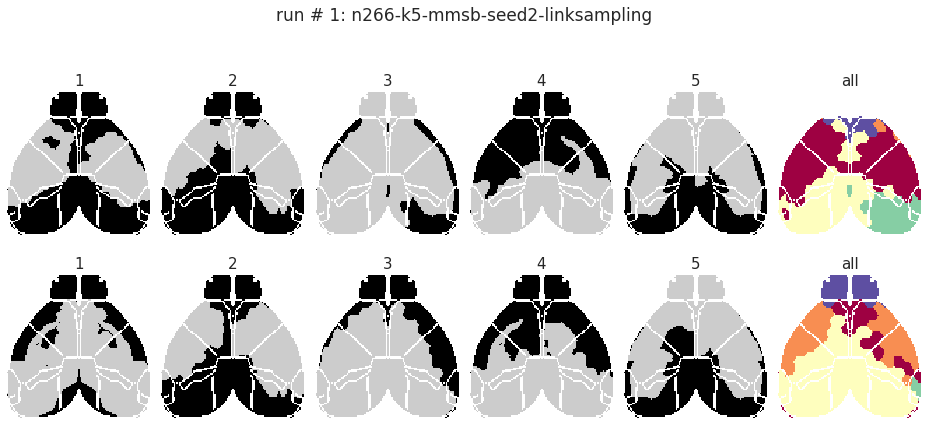

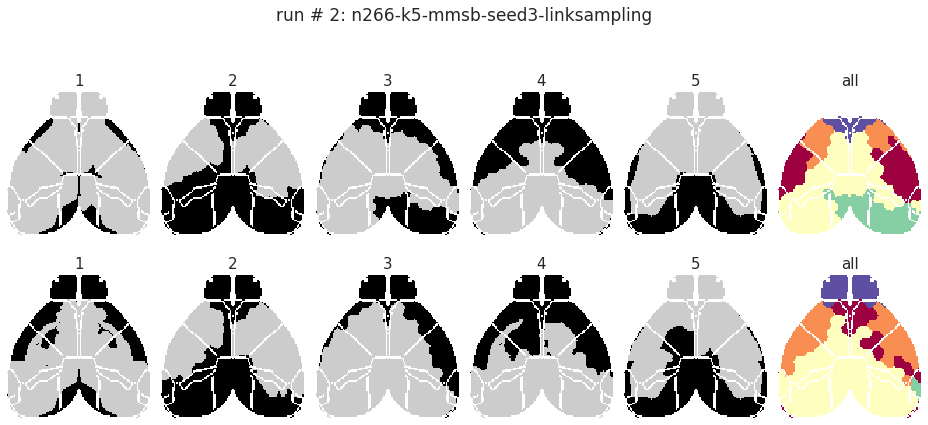

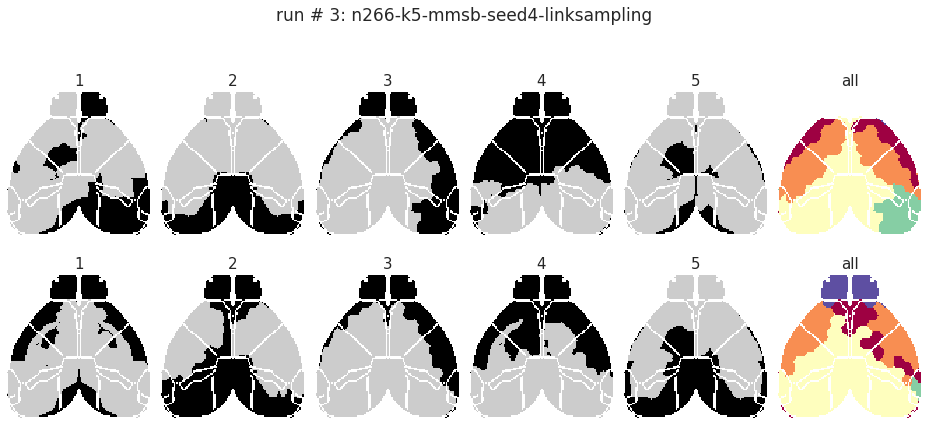

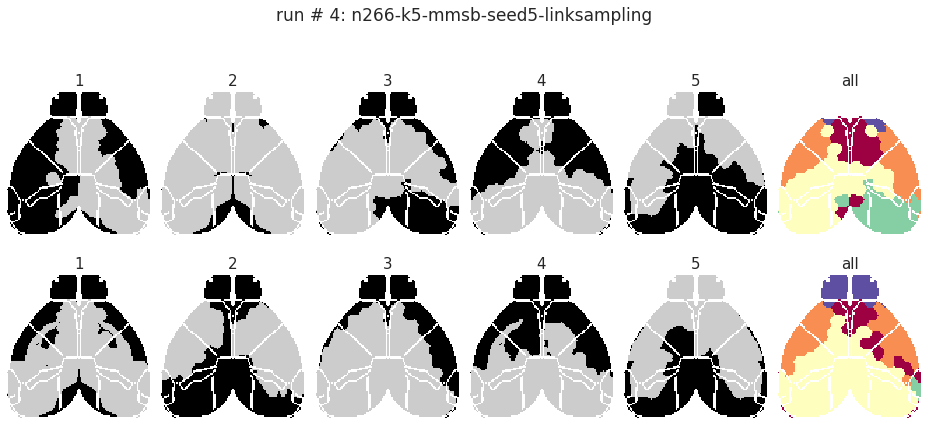

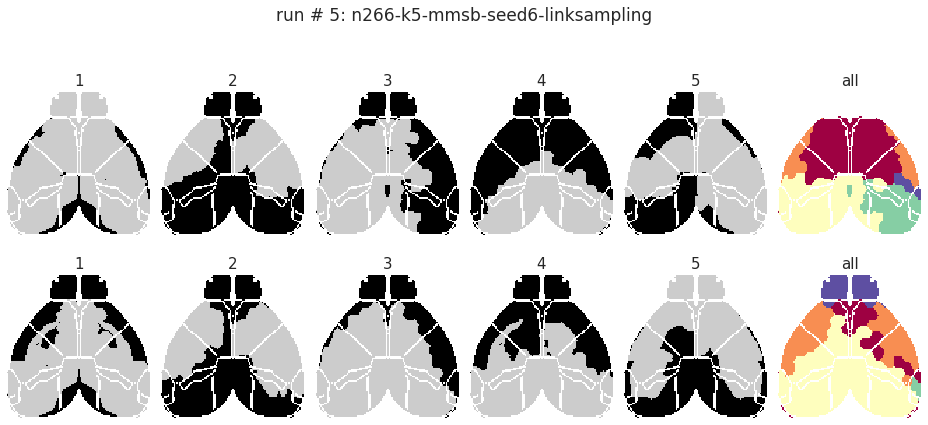

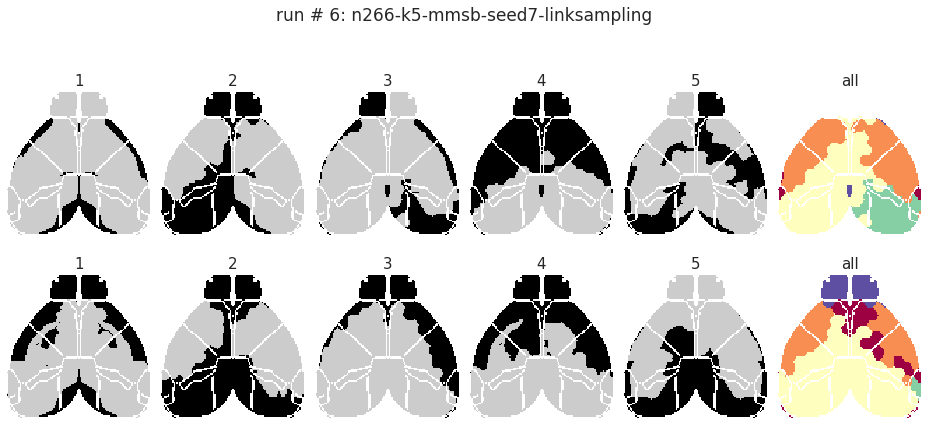

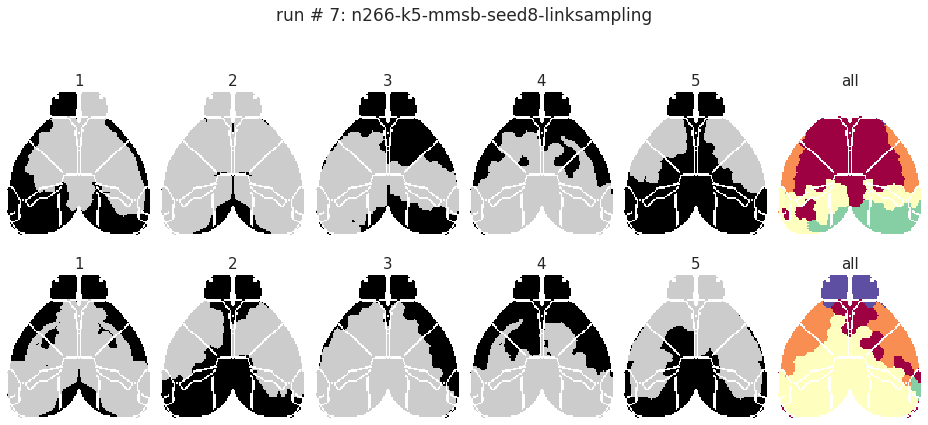

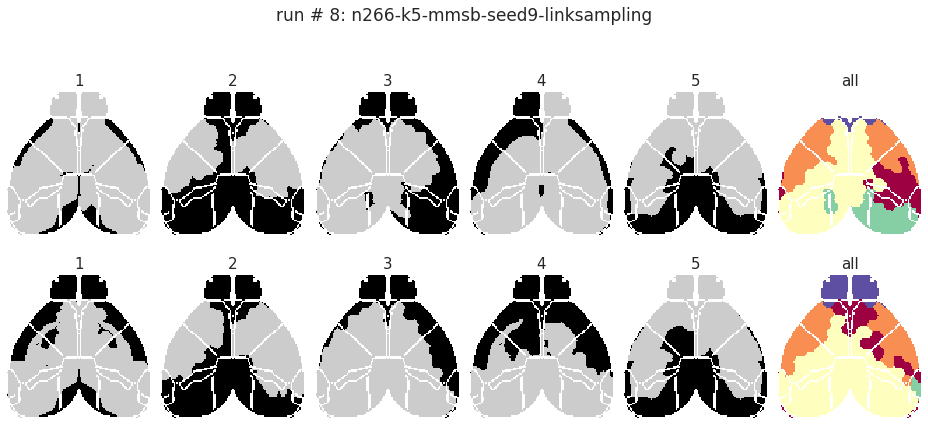

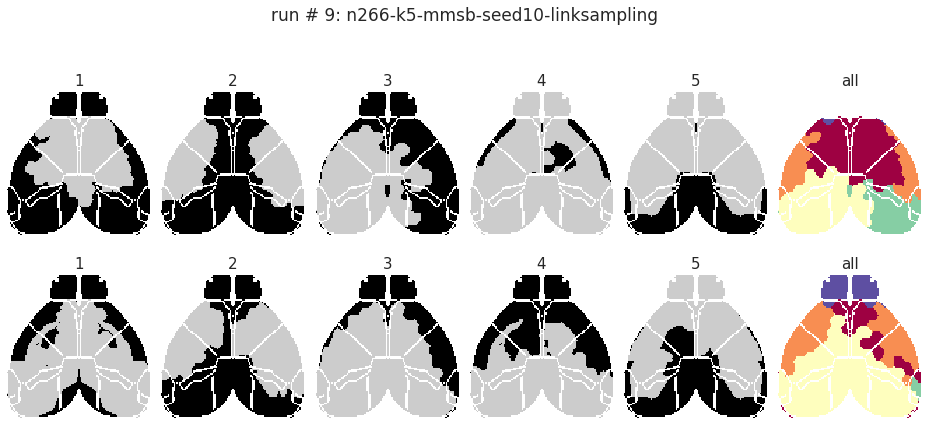

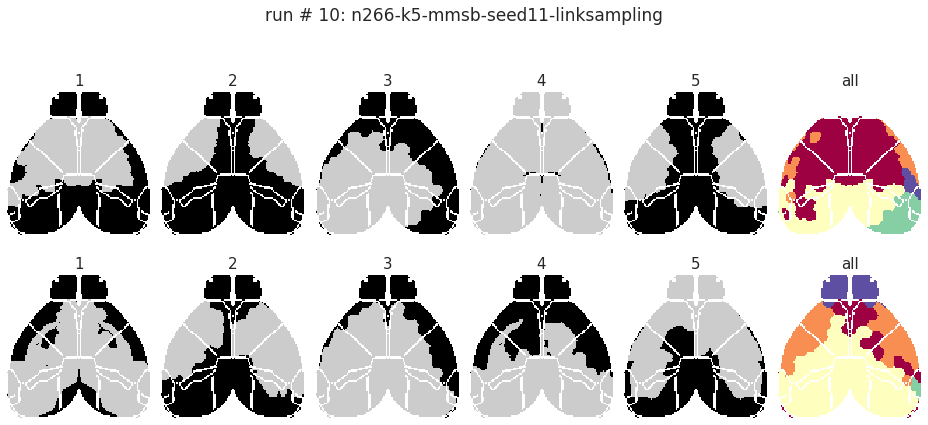

In [178]:
for run_id, (run_name, run) in enumerate(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items()):
    if run_id > 10:
        break

    memship_vecs = {
        i + 1: {
            region: pi_aligned[run_name][i, n]
            for n, region in net.node_labels.items()
        } for i in range(num_comm)
    }
    memship_vols = vec2vol(memship_vecs, mice)
    
    fig, axes = create_figure(2, num_comm + 1, (13, 6))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: memship_vols[i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

In [179]:
import ants

In [180]:
template = ants.from_numpy(mice.allen['template'].astype(float))

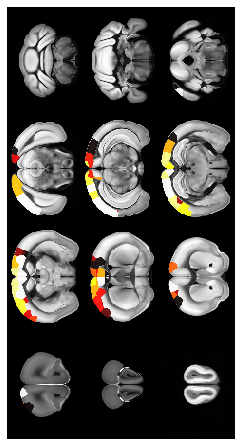

In [182]:
img = ants.from_numpy(memship_vols[3])
template.plot(
    overlay=img,
    overlay_cmap='hot',
)

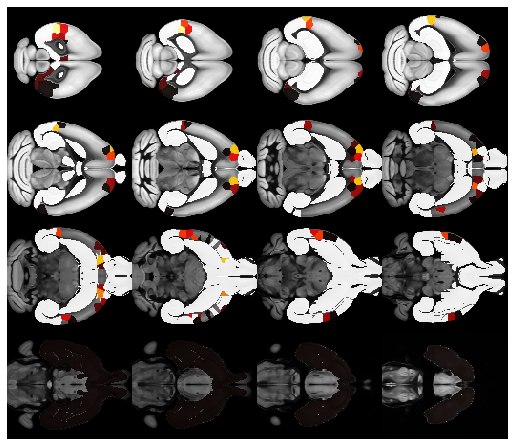

In [188]:
img = ants.from_numpy(memship_vols[4])
template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap='hot',
    axis=1,
    nslices=16,
)

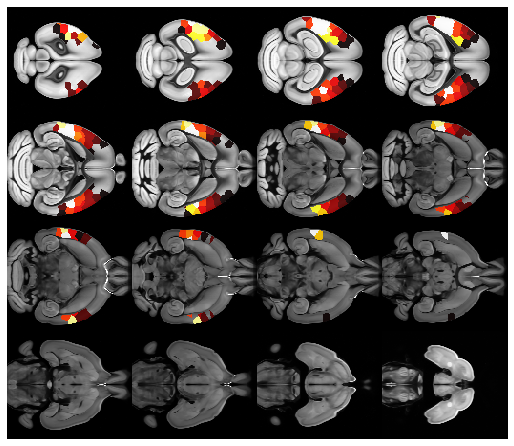

In [189]:
img = ants.from_numpy(memship_vols[5])
template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap='hot',
    axis=1,
    nslices=16,
)

In [196]:
pi_aligned = {}
for run_name, run in svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"].items():
    mapping = perms[run_name]
    pi = run['pi'][list(mapping.values())]
    pi_aligned[run_name] = np.round(pi, 1)

In [197]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [198]:
dict_list = []
for run_name in tqdm(svinet_results[f"bold_spearman_sub-SLC_n256_p-{perc}"]):
    for i in range(num_comm):
        mem = pi_aligned[run_name][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()
        counts = mem_cut.values.tolist()
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [199]:
pi_cut_df.shape

(499850, 5)

In [200]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

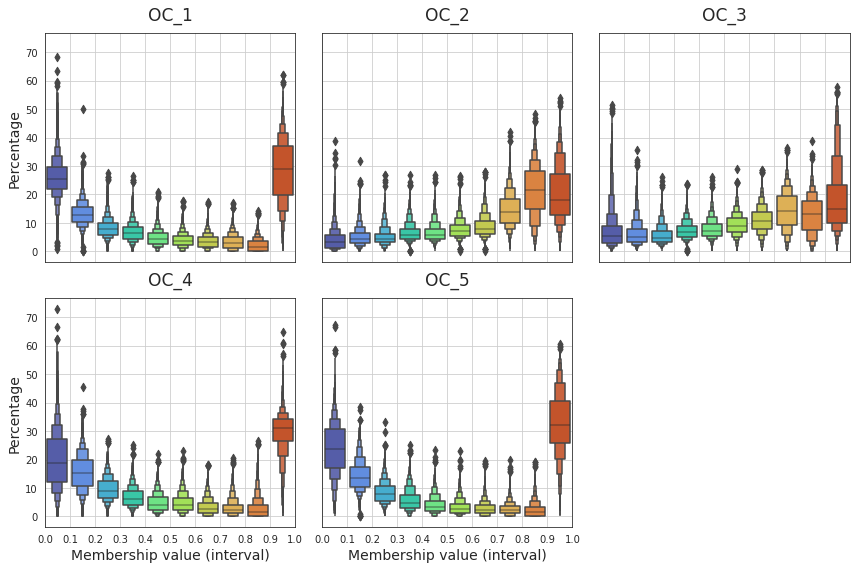

In [209]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (12, 8), 'white', 'all', 'all')

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

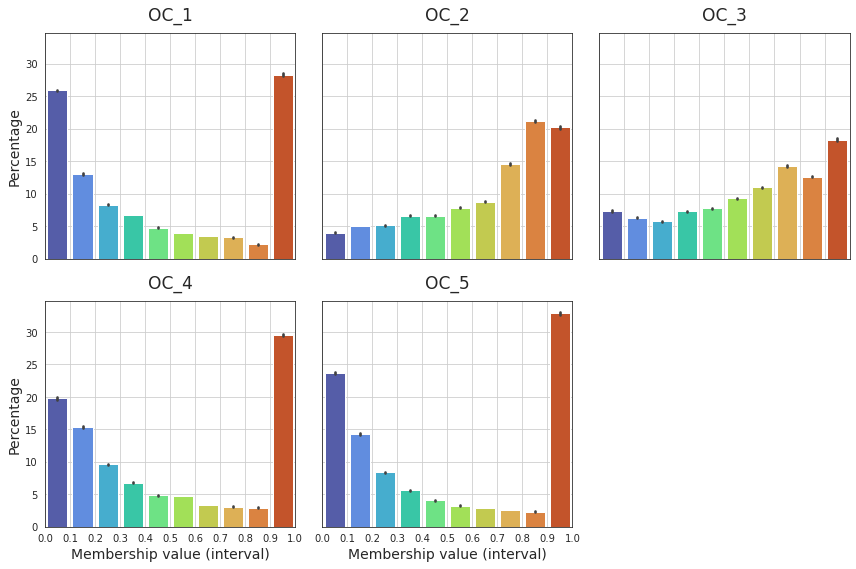

In [211]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (12, 8), 'white', 'all', 'all')

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [216]:
q = 0.674
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [318]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#92f53d',
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

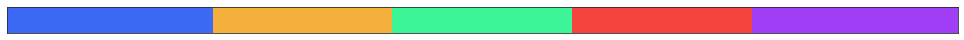

In [321]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

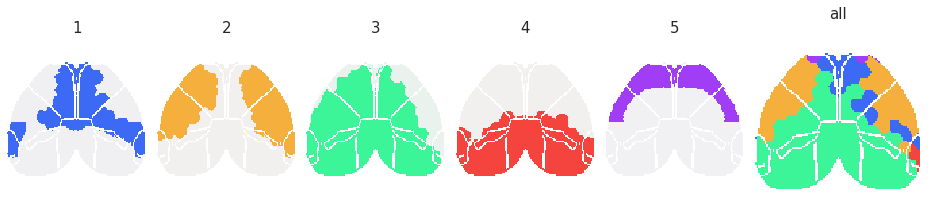

In [322]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2cluster(masks_cortex, mice.allen)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap=oc_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2cluster({i: masks_cortex[i]}, mice.allen)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=15)

remove_ticks(axes)
plt.show()

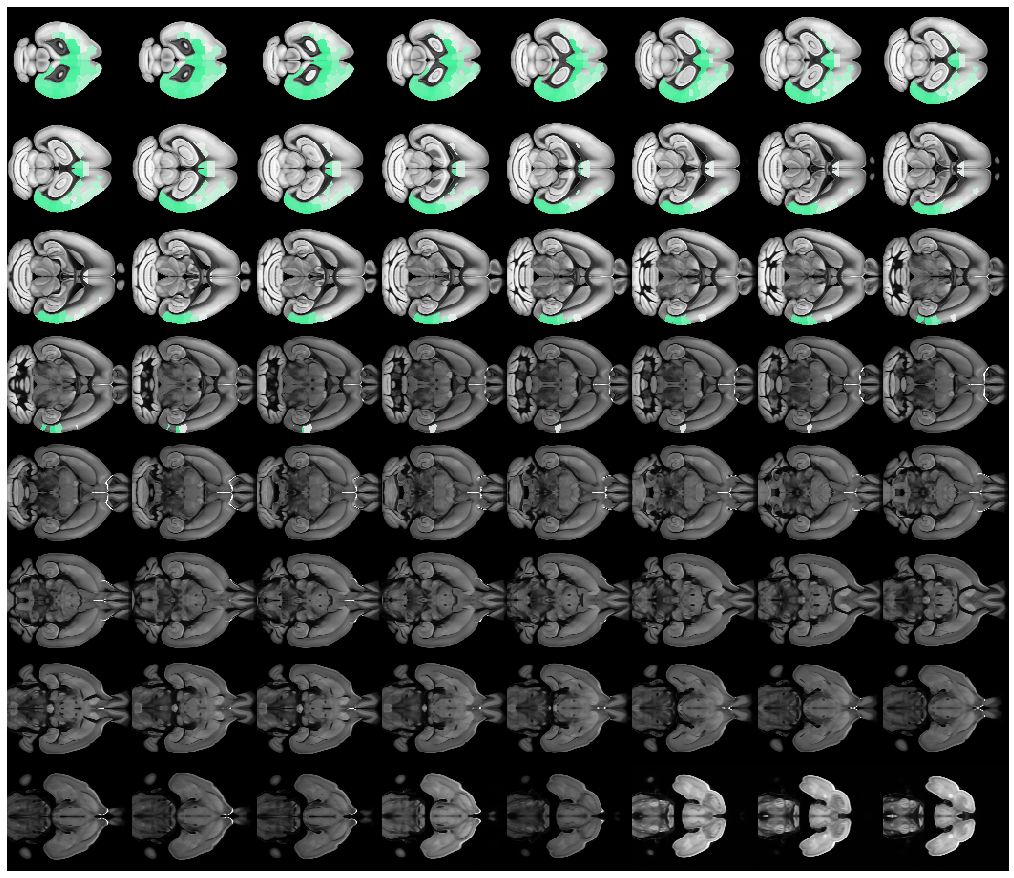

In [340]:
i = 3
img = ants.from_numpy(memship_vols[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [324]:
_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name='SVINET-canonical',
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET-canonical_parcel-5_cmap-OC.html

In [105]:
_ = parcel2html(
    masks=masks,
    save_dir=extras_dir,
    save_name='SVINET',
    cmap='Spectral',
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_parcel-3_cmap-Spectral.html

In [ ]:
prototypes = []
for comm_list in run['community'].values():
    proto = np.zeros_like(mice.allen['template'])
    for node in comm_list:
        region_id = net.node_labels[node]
        proto[mice.parcel.results['roi_masks'][region_id]] = 1
    prototypes.append(proto.reshape(1, -1))
prototypes = np.concatenate(prototypes)

### Combine results

In [62]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
canonical_comms = {}
kmeans = {}
svinet_ordered = collections.defaultdict(list)

pbar = tqdm(svinet_results)
for key in pbar:
    prototypes = []
    for run in svinet_results[key]:
        for comm_list in run['community'].values():
            proto = np.zeros_like(mice.parcel.results['parcel'])
            for node in comm_list:
                region_id = net.node_labels[node]
                proto[mice.parcel.results['parcel'] == region_id] = 1
            prototypes.append(proto.reshape(1, -1))
    prototypes = np.concatenate(prototypes)
    
    start = time()
    model = KMeans(
        n_clusters=num_comm,
        random_state=42,
    ).fit(prototypes)
    end = time()
    
    delta = convert_time(end-start, verbose=False)
    pbar.set_description(f"name: {key}, time: {delta}")
    
    kmeans[key] = model
    canonical_comms[key] = model.cluster_centers_
    
    for run in tqdm(svinet_results[key], leave=False):
        _comms = []
        for comm_idx, comm_list in run['community'].items():
            proto = np.zeros_like(mice.parcel.results['parcel'])
            for node in comm_list:
                region_id = net.node_labels[node]
                proto[mice.parcel.results['parcel'] == region_id] = 1
            _comms.append(proto.reshape(1, -1))

        canonical_idxs = model.predict(np.concatenate(_comms))
        if len(np.unique(canonical_idxs)) != num_comm:
            continue

        comm_ordered = {canonical_idxs[i]: comm_list for i, comm_list in run['community'].items()}
        result_ordered = {
            'community': dict(sorted(comm_ordered.items())),
            'membership': {n: mem_vec[canonical_idxs] for n, mem_vec in run['membership'].items()},
            'partition': {n: canonical_idxs[i] for n, i in run['partition'].items()},
        }
        svinet_ordered[key].append(result_ordered)

svinet_ordered = dict(svinet_ordered)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
proto.shape

## Hierarchical

In [7]:
hier = Hierarchical(
    mice=mice,
    key='sub-SLC',
    metric='correlation',
).fit(range(16)).make_clusters()

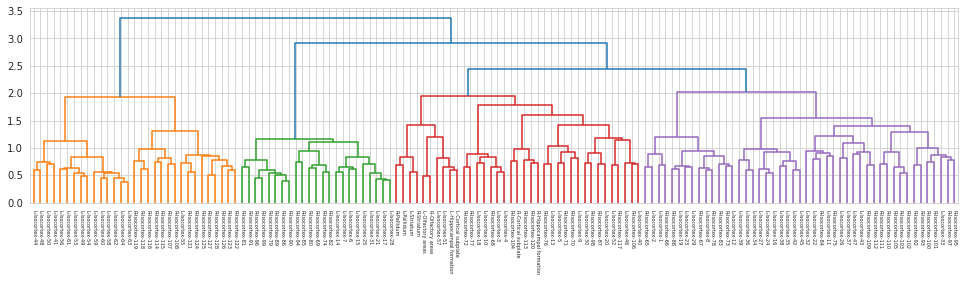

In [10]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_{now()}.pdf"
fig = hier.results[0]['fig']
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)
display(fig)

In [11]:
for n in range(2, 9):
    _ = cluster2html(
        cluster=hier.clusters[n],
        save_name='CORR-REST',
        n_cortex_regions=hier.mice.parcel.results['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-2.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-3.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-4.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-6.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-7.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-8.html

In [97]:
hier.clusters[6].export(extras_dir, f"CORR-REST-{hier.mice.parcel.results['n_cortical_regions']}")

[PROGRESS] 'CORR-REST-128-regions_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'CORR-REST-128-clusters_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

(
    '/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST-128-regions_n-6.html',
    '/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST-128-clusters_n-6.html'
)

### Embed

In [ ]:
n = 5

#### Render 3d

In [ ]:
file = f"../../_extras/CORR-REST_render-{mice.parcel.results['n_cortical_regions']}_n-{n}.html"
IFrame(file, width=1000, height=700)

#### Overlap table

In [ ]:
file = f"../../_extras/CORR-REST-{mice.parcel.results['n_cortical_regions']}-regions_n-{n}.html"
IFrame(file, width=1000, height=600)

## Load/fit hierarchical results

In [109]:
mice = Mice(Config(100))
mice.combine_dfs('rest')

In [110]:
metric = 'correlation'
load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
c_masks_dir = pjoin(load_dir, 'cluster_masks')

hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
key2hex = {k: h for h, k in hex2key.items()}

load_dir, os.listdir(load_dir)

(
    '/home/hadi/Documents/Ca-fMRI/processed/kmeans-100/results/hierarchical/correlation-(2021_07_01)',
    ['reproduc.df', 'hex2key.npy', 'fits']
)

In [111]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k, f in tqdm(key2hex.items()):
    if k not in keys_mv + [key_fx]:
        continue
    hierarchical[k] = Hierarchical(
        mice=mice,
        metric=metric,
    ).load(f, load_dir, make=False).make_cluster_masks()
list(hierarchical)

  0%|          | 0/1052 [00:00<?, ?it/s]

['sub-SLC', 'ses-1', 'ses-2', 'ses-3']

  0%|          | 0/5 [00:00<?, ?it/s]

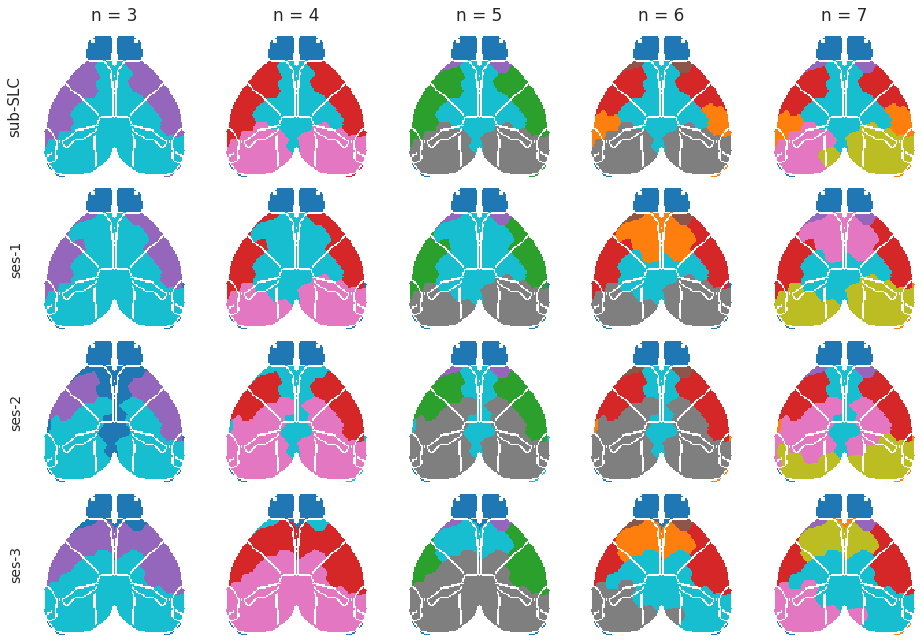

In [112]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [113]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

In [116]:
for h in hierarchical.values():
    h.make_clusters()

In [119]:
hier = hierarchical['sub-SLC']

for n, cl in hier.clusters.items():
    _ = cluster2html(
        cluster=cl,
        save_name='CORR-REST',
        n_cortex_regions=hier.mice.parcel.results['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-2.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-3.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-4.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-6.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-7.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-8.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-9.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-10.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-11.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-12.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-13.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-14.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-15.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-16.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-17.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-18.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-19.html

### 128 - LED

In [50]:
mice = Mice(Config(128))
mice.combine_dfs('led')

In [53]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k in keys_mv + [key_fx]:
    hierarchical[k] = Hierarchical(
        mice=mice,
        key=k,
        metric=metric,
    ).fit(range(2, 10)).make_cluster_masks()
list(hierarchical)

['ses-1', 'ses-2', 'ses-3', 'sub-SLC']

  0%|          | 0/8 [00:00<?, ?it/s]

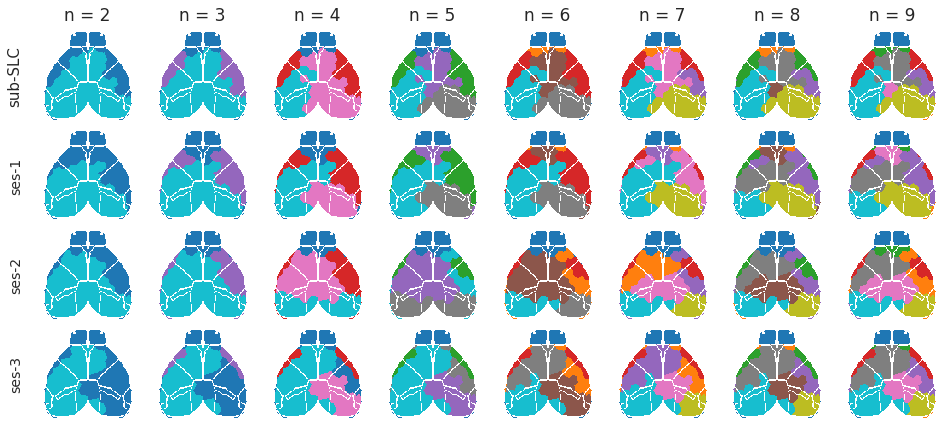

In [54]:
n_clusters = range(2, 10)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 6),
)

In [55]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

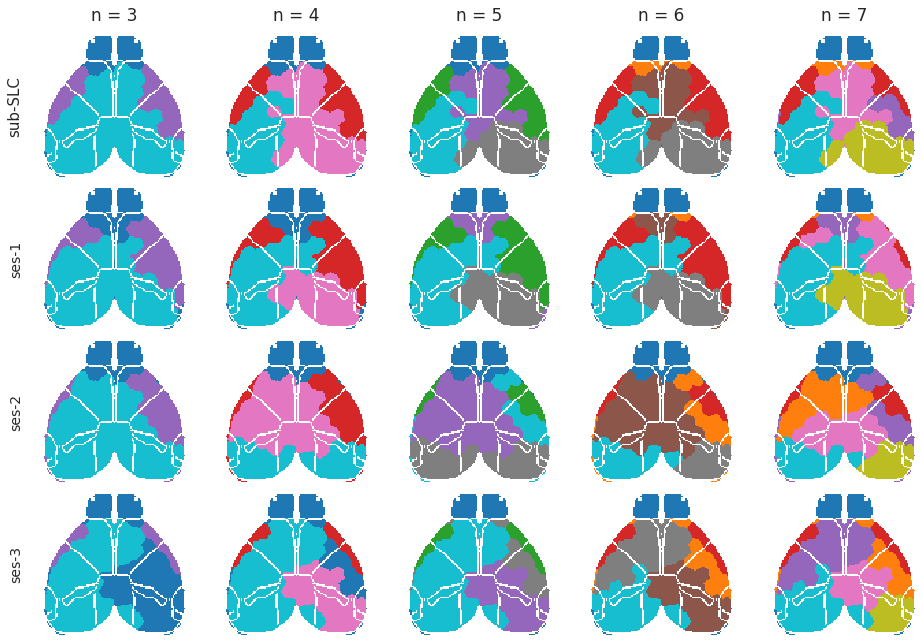

In [56]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [57]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

### 64 - REST

In [78]:
mice = Mice(Config(64))
mice.combine_dfs('rest')

In [79]:
metric = 'correlation'
load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
c_masks_dir = pjoin(load_dir, 'cluster_masks')

hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
key2hex = {k: h for h, k in hex2key.items()}

load_dir, os.listdir(load_dir)

(
    '/home/hadi/Documents/Ca-fMRI/processed/kmeans-64/results/hierarchical/correlation-(2021_06_30)',
    ['hex2key.npy', 'cluster_masks', 'fits']
)

In [80]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k, f in key2hex.items():
    if k not in keys_mv + [key_fx]:
        continue
    hierarchical[k] = Hierarchical(
        mice=mice,
        metric=metric,
    ).load(f, load_dir, make=False).make_cluster_masks()
list(hierarchical)

['sub-SLC', 'ses-1', 'ses-2', 'ses-3']

  0%|          | 0/8 [00:00<?, ?it/s]

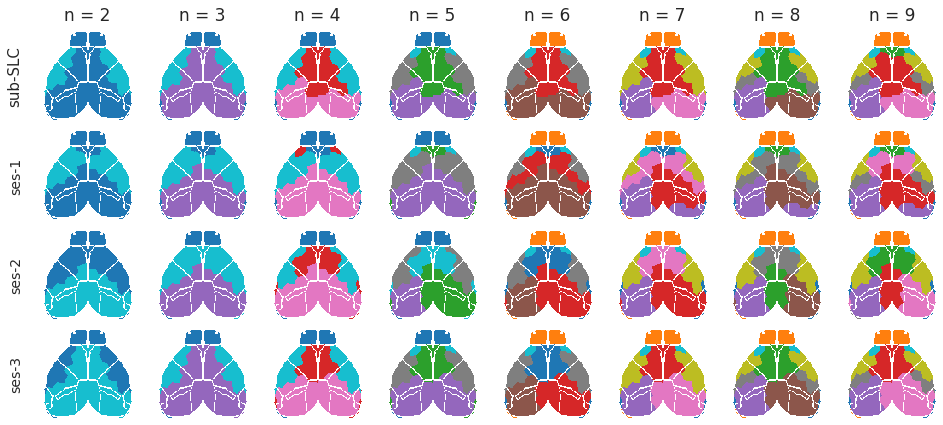

In [81]:
n_clusters = range(2, 10)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 6),
)

In [82]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

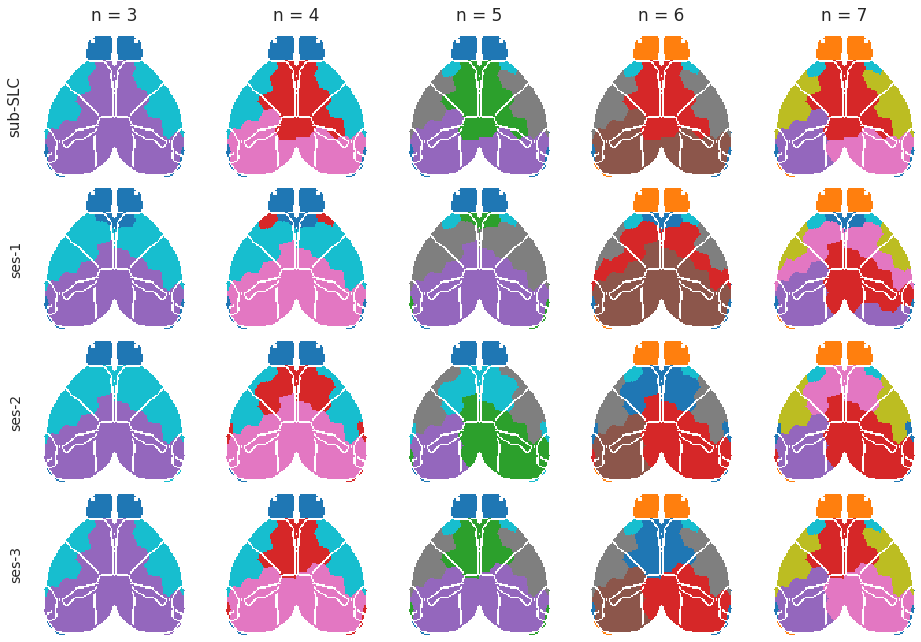

In [83]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [84]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

### 64 - LED

In [91]:
mice = Mice(Config(64))
mice.combine_dfs('led')

In [92]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k in keys_mv + [key_fx]:
    hierarchical[k] = Hierarchical(
        mice=mice,
        key=k,
        metric=metric,
    ).fit(range(2, 10)).make_cluster_masks()
list(hierarchical)

['ses-1', 'ses-2', 'ses-3', 'sub-SLC']

  0%|          | 0/8 [00:00<?, ?it/s]

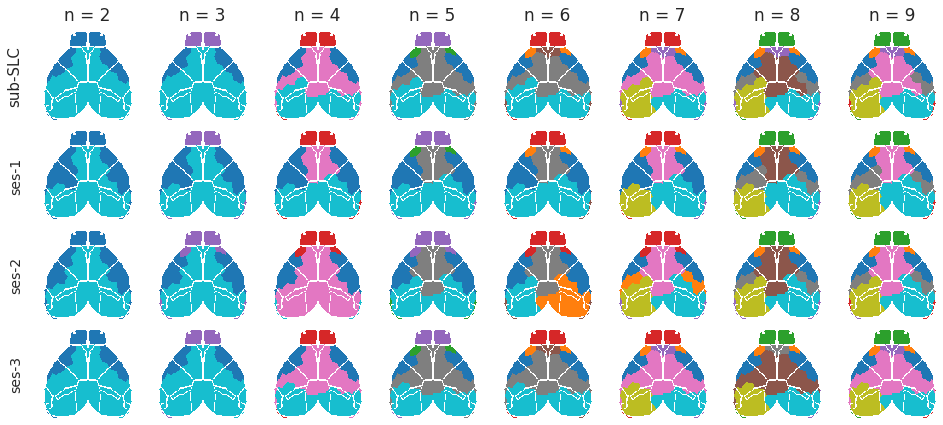

In [93]:
n_clusters = range(2, 10)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 6),
)

In [94]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

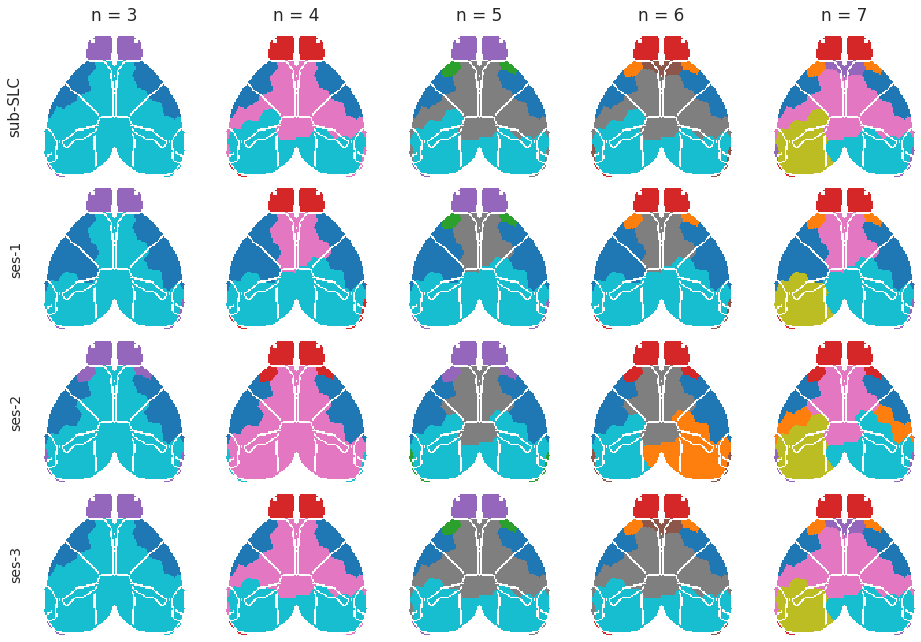

In [95]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [96]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

## Symmetry score

In [6]:
n_clusters = range(2, 10)
metric = 'correlation'
keys = ['sub-SLC', 'ses-1', 'ses-2', 'ses-3']

dict_list = []
for n in tqdm([64, 128, 512, 1024]):
    mice = Mice(Config(n))
    mice.combine_dfs('rest')
    
    load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
    load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
    c_masks_dir = pjoin(load_dir, 'cluster_masks')
    hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
    key2hex = {k: h for h, k in hex2key.items()}
    
    hierarchical = {}
    for k, f in key2hex.items():
        if k not in keys:
            continue
        hierarchical[k] = Hierarchical(
            mice=mice,
            metric=metric,
        ).load(f, load_dir, make=False).make_cluster_masks()

    for k in keys:
        for n in n_clusters:
            masks = hierarchical[k].results[n]['cluster_masks']
            sym_scores = [
                symmetry_score(m, mice.parcel.results['mask_l'], mice.parcel.results['mask_r'])
                for m in masks.values()
            ]
            data_dict = {
                'n_rois': [mice.parcel.results['n_cortical_regions']],
                'n_clusters': [n],
                'tag': [k],
                'metric': [metric],
                'dist_measure': ['symmetry'],
                'val': [weighted_score(sym_scores, masks)],
                'val_mean': [np.mean(sym_scores)],
                'val_median': [np.median(sym_scores)],
            }
            dict_list.append(data_dict)
sym_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/4 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

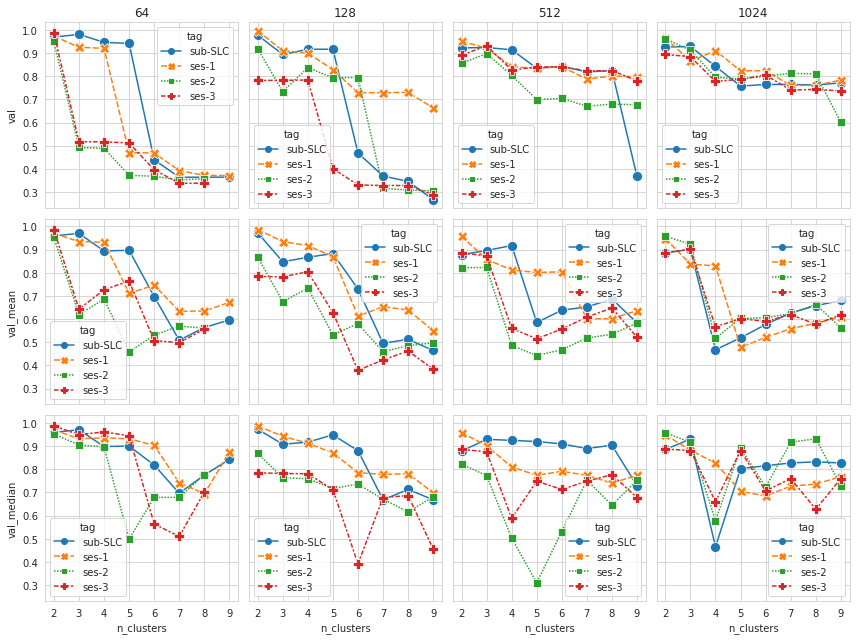

In [8]:
fig, axes = create_figure(3, 4, (12, 9), True, 'whitegrid', 'all', 'all')

for j, n in enumerate(sym_df.n_rois.unique()):
    for i, (ax, val) in enumerate(zip(axes[:, j], ['val', 'val_mean', 'val_median'])):
        selected_df = sym_df.loc[sym_df.n_rois == n]
        sns.lineplot(
            data=selected_df,
            x='n_clusters',
            y=val,
            hue='tag',
            style='tag',
            markers=True,
            markersize=10,
            estimator=np.mean,
            ci='sd',
            alpha=1.0,
            legend=True,
            palette='tab10',
            ax=ax,
        )
        ax.set_xticks(n_clusters)
        if i == 0:
            ax.set_title(n)
plt.show()

<AxesSubplot:xlabel='n_clusters', ylabel='val_mean'>

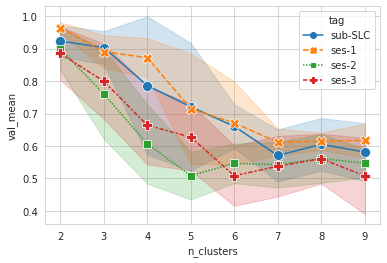

In [9]:
sns.lineplot(
    data=sym_df,
    x='n_clusters',
    y='val_mean',
    hue='tag',
    style='tag',
    markers=True,
    markersize=10,
    estimator=np.mean,
    ci='sd',
    alpha=1.0,
    legend=True,
    palette='tab10',
)

In [13]:
x3d, x2d = masks2cluster(masks, mice.allen)
x2d = x2d.astype(float)

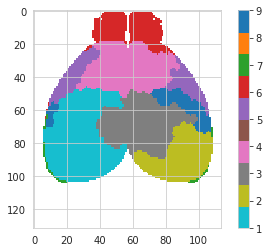

In [15]:
x2d[x2d == 0] = np.nan
plt.imshow(x2d, cmap='tab10_r')
plt.colorbar()
plt.show()

## Reproc

In [121]:

n_rois

[8, 16, 32, 64, 100, 128, 200, 256, 300, 400, 500, 512, 600, 700, 800, 900, 1024]

In [122]:
metric = 'correlation'
n_rois = [2**i for i in range(3, 11)] + [100 * i for i in range(1, 10)]
n_rois = sorted(n_rois)

df = pd.DataFrame()
for n in n_rois:
    _dir = pjoin(Config(n).results_dir, 'hierarchical')
    matching_fits = [x for x in os.listdir(_dir) if metric in x]
    selected_fit = sorted(matching_fits)[-1]
    load_dir = pjoin(_dir, selected_fit)
    print(n, os.listdir(load_dir))
    df = pd.concat([df, pd.read_pickle(pjoin(load_dir, 'reproduc.df'))])

df = reset_df(df, 'none')

8
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

16
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

32
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

64
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

100
['reproduc.df', 'hex2key.npy', 'fits']

128
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

200
['reproduc.df', 'hex2key.npy', 'fits']

256
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

300
['reproduc.df', 'hex2key.npy', 'fits']

400
['reproduc.df', 'hex2key.npy', 'fits']

500
['reproduc.df', 'hex2key.npy', 'fits']

512
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

600
['reproduc.df', 'hex2key.npy', 'fits']

700
['reproduc.df', 'hex2key.npy', 'fits']

800
['reproduc.df', 'hex2key.npy', 'fits']

900
['reproduc.df', 'hex2key.npy', 'fits']

1024
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

In [123]:
df.shape

(1041012, 9)

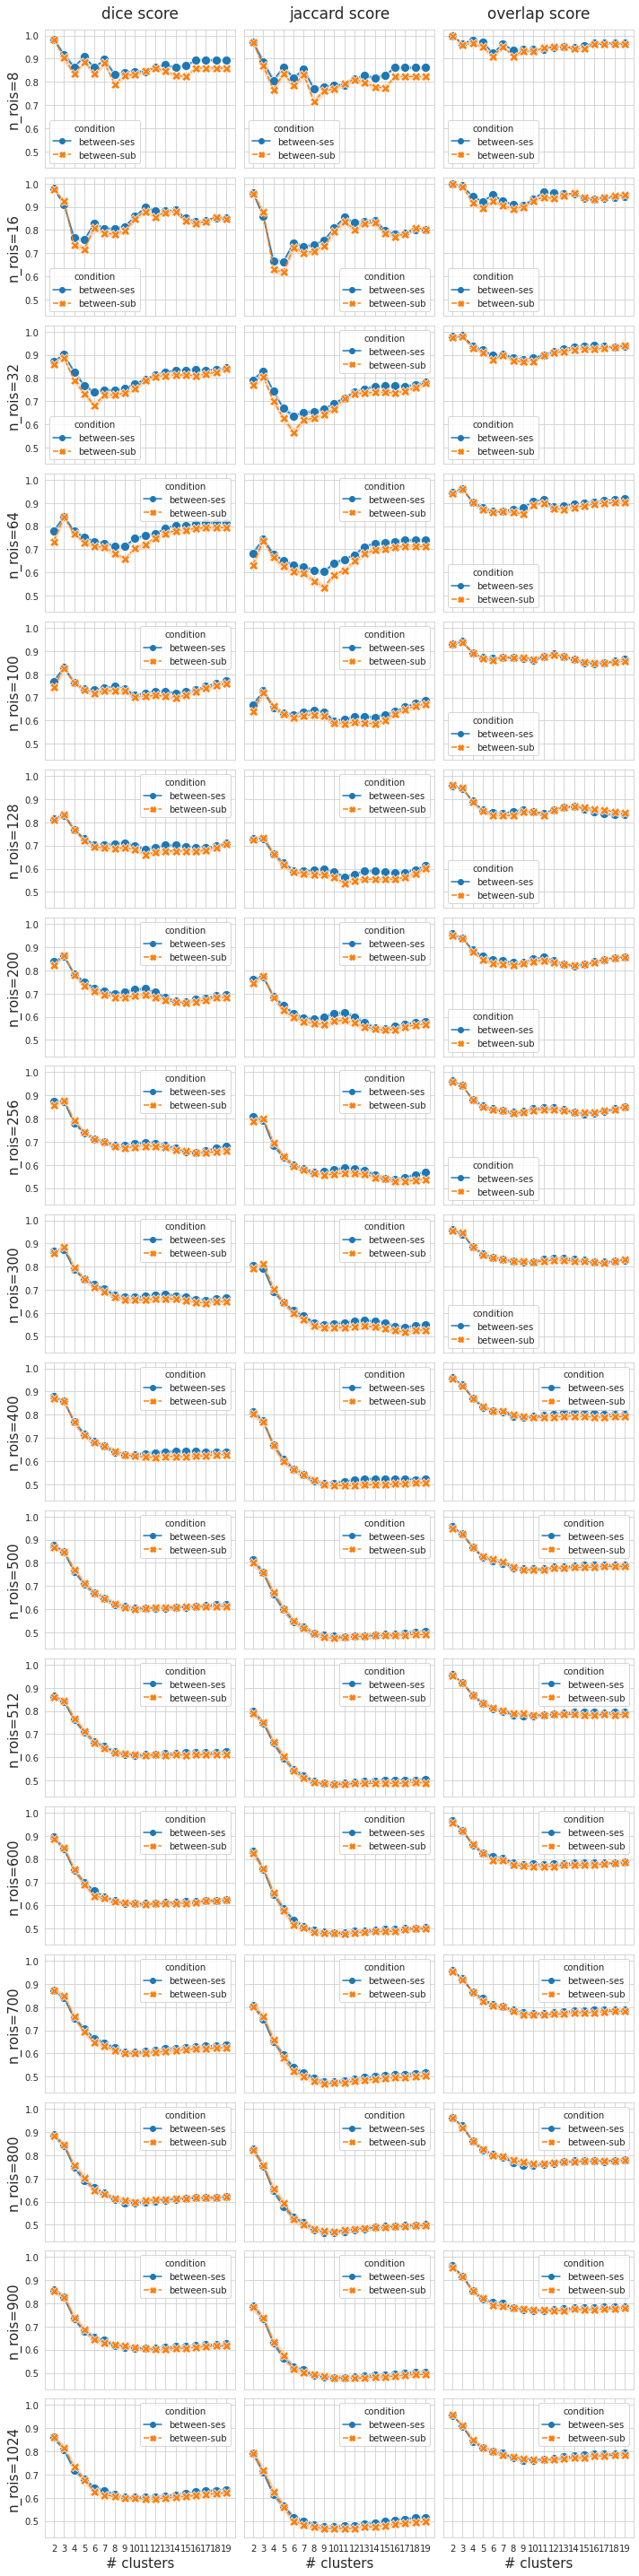

In [129]:
fig, axes = create_figure(len(n_rois), 3, (10, 40), True, 'whitegrid', 'all', 'all')

for i, n in enumerate(sorted(df.n_rois.unique())):
    for j, (ax, dist_measure) in enumerate(zip(axes[i], ['dice', 'jaccard', 'overlap'])):
        selected_df = df.loc[
            (df.dist_measure == dist_measure) &
            (df.n_rois == n)
        ]
        sns.lineplot(
            data=selected_df,
            x='n_clusters',
            y='val',
            hue='condition',
            style='condition',
            markers=True,
            markersize=10,
            estimator=np.mean,
            ci=95,
            alpha=1.0,
            legend=True,
            ax=ax,
        )
        if i == 0:
            ax.set_title(f"{dist_measure} score", fontsize=17, y=1.04)
        if j == 0:
            ax.set_ylabel(f"n_rois={n}", fontsize=15)
        # ax.set_title(dist_measure, fontsize=17, y=1.02)
        # ax.set_ylabel('similarity score', fontsize=15)
        ax.set_xlabel('# clusters', fontsize=15)
        ax.set_xticks(df.n_clusters.unique())

fig.savefig(pjoin(tmp_dir, f"reproducibility_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

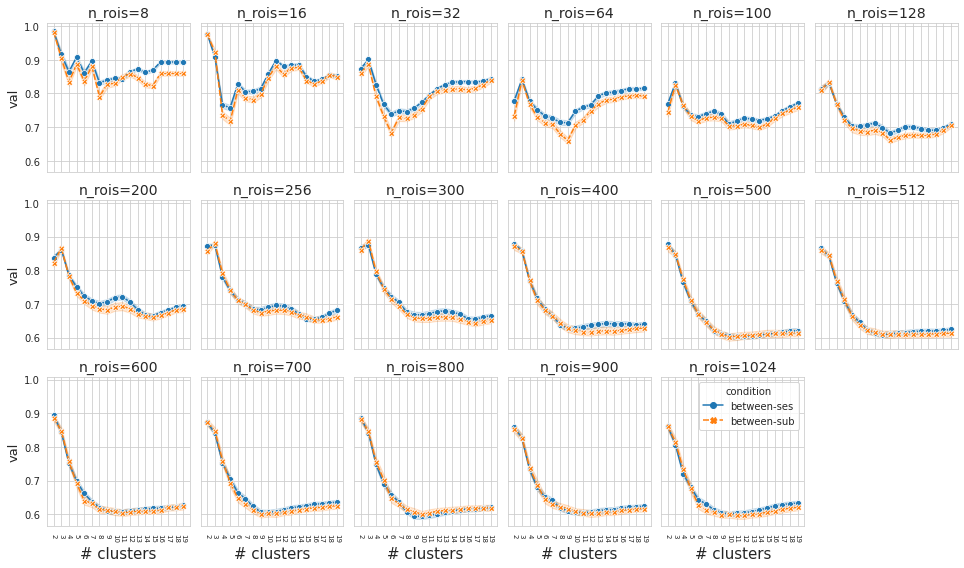

In [160]:
ncols = 6
nrows = int(np.ceil(len(n_rois) / ncols))
fig, axes = create_figure(nrows, ncols, (13.5, 8), 'whitegrid', 'all', 'all', True)

for idx, n in enumerate(sorted(df.n_rois.unique())):
    i, j = idx//ncols, idx%ncols
    selected_df = df.loc[
        (df.dist_measure == 'dice') &
        (df.n_rois == n)
    ]
    line = sns.lineplot(
        data=selected_df,
        x='n_clusters',
        y='val',
        hue='condition',
        style='condition',
        markers=True,
        markersize=6,
        estimator=np.mean,
        ci=95,
        alpha=1.0,
        legend=True if idx == len(n_rois) - 1 else False,
        ax=axes[i,j],
    )
    # leg = line.get_legend()
    # if leg is not None:
        # plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=12)
        # plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=11)
        # plt.setp(leg.get_title(), text='Mode', fontsize=11)
        # plt.setp(leg, bbox_to_anchor=(2, 0.77))
        
    axes[i,j].set_title(f"n_rois={n}", fontsize=14, y=1.0)
    if j == 0:
        axes[i,j].set_ylabel('val', fontsize=13)
    else:
        axes[i,j].set_ylabel('', fontsize=13)

    axes[i,j].set_xlabel('# clusters', fontsize=15)
    axes[i,j].set_xticks(df.n_clusters.unique())
    axes[i,j].tick_params('x', rotation=-90, labelsize=7)
_ = trim_axs(axes, len(n_rois))

fig.savefig(pjoin(tmp_dir, f"reproduc_dice_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

In [189]:
selected_df = df.loc[df.dist_measure == 'dice']
selected_df = selected_df.groupby(['n_rois', 'n_clusters', 'condition', 'sessions']).mean()
selected_df.shape

(1836, 3)

In [190]:
selected_df

val 
 val_mean 
 val_median 
 
 
 n_rois 
 n_clusters 
 condition 
 sessions 
 
 
 
 
 
 
 
 8 
 2 
 between-ses 
 ses-1_vs_ses-2 
 0.981848 
 0.490924 
 0.490924 
 
 
 ses-1_vs_ses-3 
 0.987215 
 0.493607 
 0.493607 
 
 
 ses-2_vs_ses-3 
 0.983425 
 0.491713 
 0.491713 
 
 
 between-sub 
 ses-1_vs_ses-1 
 0.986292 
 0.493146 
 0.493146 
 
 
 ses-2_vs_ses-2 
 0.975979 
 0.487989 
 0.487989 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1024 
 19 
 between-ses 
 ses-1_vs_ses-3 
 0.635751 
 0.033461 
 0.013499 
 
 
 ses-2_vs_ses-3 
 0.626693 
 0.032984 
 0.013240 
 
 
 between-sub 
 ses-1_vs_ses-1 
 0.577866 
 0.030414 
 0.012975 
 
 
 ses-2_vs_ses-2 
 0.616983 
 0.032473 
 0.013006 
 
 
 ses-3_vs_ses-3 
 0.667628 
 0.035138 
 0.013273 
 
 
 
 1836 rows × 3 columns

In [196]:
selected_df = df.loc[df.dist_measure == 'dice']
selected_df = selected_df.groupby(['n_rois', 'n_clusters']).mean()
selected_df

val 
 val_mean 
 val_median 
 
 
 n_rois 
 n_clusters 
 
 
 
 
 
 
 
 8 
 2 
 0.983936 
 0.491968 
 0.491968 
 
 
 3 
 0.912543 
 0.304181 
 0.251601 
 
 
 4 
 0.854356 
 0.213589 
 0.219037 
 
 
 5 
 0.901084 
 0.180217 
 0.186883 
 
 
 6 
 0.852890 
 0.142148 
 0.142683 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1024 
 15 
 0.614231 
 0.040949 
 0.017755 
 
 
 16 
 0.619993 
 0.038750 
 0.016370 
 
 
 17 
 0.623874 
 0.036698 
 0.015190 
 
 
 18 
 0.627277 
 0.034849 
 0.014186 
 
 
 19 
 0.629109 
 0.033111 
 0.013228 
 
 
 
 306 rows × 3 columns

In [197]:
selected_df.index

MultiIndex([(   8,  2),
            (   8,  3),
            (   8,  4),
            (   8,  5),
            (   8,  6),
            (   8,  7),
            (   8,  8),
            (   8,  9),
            (   8, 10),
            (   8, 11),
            ...
            (1024, 10),
            (1024, 11),
            (1024, 12),
            (1024, 13),
            (1024, 14),
            (1024, 15),
            (1024, 16),
            (1024, 17),
            (1024, 18),
            (1024, 19)],
           names=['n_rois', 'n_clusters'], length=306)

In [198]:
selected_df = selected_df.unstack()
selected_df.columns

MultiIndex([(       'val',  2),
            (       'val',  3),
            (       'val',  4),
            (       'val',  5),
            (       'val',  6),
            (       'val',  7),
            (       'val',  8),
            (       'val',  9),
            (       'val', 10),
            (       'val', 11),
            (       'val', 12),
            (       'val', 13),
            (       'val', 14),
            (       'val', 15),
            (       'val', 16),
            (       'val', 17),
            (       'val', 18),
            (       'val', 19),
            (  'val_mean',  2),
            (  'val_mean',  3),
            (  'val_mean',  4),
            (  'val_mean',  5),
            (  'val_mean',  6),
            (  'val_mean',  7),
            (  'val_mean',  8),
            (  'val_mean',  9),
            (  'val_mean', 10),
            (  'val_mean', 11),
            (  'val_mean', 12),
            (  'val_mean', 13),
            (  'val_mean', 14),
            (  'val_mean', 15),
            (  'val_mean', 16),
            (  'val_mean', 17),
            (  'val_mean', 18),
            (  'val_mean', 19),
            ('val_median',  2),
            ('val_median',  3),
            ('val_median',  4),
            ('val_median',  5),
            ('val_median',  6),
            ('val_median',  7),
            ('val_median',  8),
            ('val_median',  9),
            ('val_median', 10),
            ('val_median', 11),
            ('val_median', 12),
            ('val_median', 13),
            ('val_median', 14),
            ('val_median', 15),
            ('val_median', 16),
            ('val_median', 17),
            ('val_median', 18),
            ('val_median', 19)],
           names=[None, 'n_clusters'])

In [199]:
selected_df

val 
 ... 
 val_median 
 
 
 n_clusters 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 ... 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 
 
 n_rois 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8 
 0.983936 
 0.912543 
 0.854356 
 0.901084 
 0.852890 
 0.891256 
 0.818029 
 0.835418 
 0.840424 
 0.845847 
 ... 
 0.086646 
 0.075719 
 0.061591 
 0.052219 
 0.051611 
 0.051717 
 0.053924 
 0.053924 
 0.053924 
 0.053924 
 
 
 16 
 0.977423 
 0.913161 
 0.755766 
 0.744283 
 0.821786 
 0.799296 
 0.797956 
 0.808573 
 0.854603 
 0.892187 
 ... 
 0.073705 
 0.067575 
 0.064750 
 0.061665 
 0.058477 
 0.048013 
 0.038636 
 0.033769 
 0.031990 
 0.029311 
 
 
 32 
 0.869114 
 0.896224 
 0.814986 
 0.755976 
 0.719923 
 0.741859 
 0.739748 
 0.749417 
 0.768070 
 0.793833 
 ... 
 0.062842 
 0.058035 
 0.053777 
 0.048718 
 0.043111 
 0.037875 
 0.034694 
 0.032678 
 0.031296 
 0.030231 
 
 
 64 
 0.763850 
 0.841369 
 0.774254 
 0.745030 
 0.726706 
 0.720622 
 0.702969 
 0.695410 
 0.733375 
 0.746186 
 ... 
 0.050555 
 0.045405 
 0.043975 
 0.041410 
 0.037949 
 0.033840 
 0.030396 
 0.027229 
 0.024510 
 0.022275 
 
 
 100 
 0.761468 
 0.829246 
 0.763576 
 0.734416 
 0.727219 
 0.735942 
 0.741690 
 0.734260 
 0.707327 
 0.713467 
 ... 
 0.041495 
 0.040433 
 0.036950 
 0.033775 
 0.030960 
 0.028135 
 0.025753 
 0.023642 
 0.021957 
 0.020638 
 
 
 128 
 0.813014 
 0.832220 
 0.768412 
 0.727063 
 0.700986 
 0.697718 
 0.700333 
 0.704975 
 0.693987 
 0.675550 
 ... 
 0.037344 
 0.034867 
 0.032950 
 0.030011 
 0.027267 
 0.024978 
 0.023072 
 0.021600 
 0.020246 
 0.019037 
 
 
 200 
 0.832402 
 0.862819 
 0.783589 
 0.744600 
 0.719006 
 0.704416 
 0.695746 
 0.698228 
 0.709267 
 0.711994 
 ... 
 0.034258 
 0.030892 
 0.028161 
 0.025950 
 0.024506 
 0.023054 
 0.021654 
 0.020173 
 0.018907 
 0.017623 
 
 
 256 
 0.867887 
 0.876213 
 0.783653 
 0.740023 
 0.711737 
 0.699666 
 0.683242 
 0.680043 
 0.686127 
 0.690703 
 ... 
 0.034918 
 0.031165 
 0.027713 
 0.024839 
 0.023113 
 0.021841 
 0.020626 
 0.019573 
 0.018512 
 0.017486 
 
 
 300 
 0.865083 
 0.879521 
 0.790647 
 0.747078 
 0.719110 
 0.700917 
 0.673692 
 0.665048 
 0.664053 
 0.666460 
 ... 
 0.033016 
 0.029484 
 0.026575 
 0.024136 
 0.022450 
 0.020989 
 0.019950 
 0.019093 
 0.018244 
 0.017254 
 
 
 400 
 0.875371 
 0.858177 
 0.769549 
 0.714378 
 0.683547 
 0.665078 
 0.640094 
 0.627356 
 0.625539 
 0.627563 
 ... 
 0.030456 
 0.027549 
 0.025108 
 0.023100 
 0.021266 
 0.019496 
 0.018032 
 0.016870 
 0.015861 
 0.014986 
 
 
 500 
 0.873714 
 0.847074 
 0.767055 
 0.709060 
 0.669861 
 0.647282 
 0.621381 
 0.611016 
 0.603618 
 0.603762 
 ... 
 0.029872 
 0.027351 
 0.024693 
 0.022257 
 0.020316 
 0.018490 
 0.017005 
 0.015716 
 0.014759 
 0.013819 
 
 
 512 
 0.863398 
 0.841823 
 0.764592 
 0.710343 
 0.666776 
 0.643284 
 0.622599 
 0.614389 
 0.609312 
 0.610351 
 ... 
 0.030238 
 0.027689 
 0.025231 
 0.022798 
 0.020649 
 0.018899 
 0.017411 
 0.016172 
 0.015068 
 0.014081 
 
 
 600 
 0.891963 
 0.845565 
 0.752989 
 0.696525 
 0.654759 
 0.636028 
 0.618394 
 0.611233 
 0.608379 
 0.606231 
 ... 
 0.030829 
 0.027330 
 0.024508 
 0.022202 
 0.020078 
 0.018240 
 0.016690 
 0.015536 
 0.014511 
 0.013685 
 
 
 700 
 0.873273 
 0.843256 
 0.754957 
 0.702049 
 0.659133 
 0.641318 
 0.619820 
 0.604490 
 0.605082 
 0.606333 
 ... 
 0.029961 
 0.027170 
 0.024562 
 0.022369 
 0.020336 
 0.018540 
 0.017145 
 0.015775 
 0.014643 
 0.013618 
 
 
 800 
 0.886019 
 0.843581 
 0.751078 
 0.695345 
 0.654751 
 0.634824 
 0.610276 
 0.598662 
 0.595849 
 0.599570 
 ... 
 0.029872 
 0.027266 
 0.024513 
 0.021795 
 0.019727 
 0.017806 
 0.016322 
 0.014956 
 0.013868 
 0.012973 
 
 
 900 
 0.857916 
 0.826671 
 0.735314 
 0.682687 
 0.649658 
 0.637591 
 0.619418 
 0.612602 
 0.606715 
 0.605191 
 ... 
 0.030169 
 0.026933 
 0.024427 
 0.021922 
 0.019848 
 0.018068 
 0.016593 
 0.015230 
 0.014111 
 0.013142 
 
 
 1024 
 0.861399 
 0.809503

In [200]:
selected_df.val

n_clusters 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 
 
 n_rois 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8 
 0.983936 
 0.912543 
 0.854356 
 0.901084 
 0.852890 
 0.891256 
 0.818029 
 0.835418 
 0.840424 
 0.845847 
 0.862455 
 0.864478 
 0.850626 
 0.854457 
 0.882241 
 0.882241 
 0.882241 
 0.882241 
 
 
 16 
 0.977423 
 0.913161 
 0.755766 
 0.744283 
 0.821786 
 0.799296 
 0.797956 
 0.808573 
 0.854603 
 0.892187 
 0.873252 
 0.880650 
 0.883039 
 0.846469 
 0.833752 
 0.840184 
 0.854146 
 0.851994 
 
 
 32 
 0.869114 
 0.896224 
 0.814986 
 0.755976 
 0.719923 
 0.741859 
 0.739748 
 0.749417 
 0.768070 
 0.793833 
 0.811868 
 0.820822 
 0.826832 
 0.827604 
 0.827286 
 0.827590 
 0.833099 
 0.842786 
 
 
 64 
 0.763850 
 0.841369 
 0.774254 
 0.745030 
 0.726706 
 0.720622 
 0.702969 
 0.695410 
 0.733375 
 0.746186 
 0.760054 
 0.784417 
 0.794649 
 0.796968 
 0.802362 
 0.807213 
 0.807454 
 0.807599 
 
 
 100 
 0.761468 
 0.829246 
 0.763576 
 0.734416 
 0.727219 
 0.735942 
 0.741690 
 0.734260 
 0.707327 
 0.713467 
 0.720550 
 0.718030 
 0.712711 
 0.719611 
 0.730909 
 0.746171 
 0.756881 
 0.766993 
 
 
 128 
 0.813014 
 0.832220 
 0.768412 
 0.727063 
 0.700986 
 0.697718 
 0.700333 
 0.704975 
 0.693987 
 0.675550 
 0.683602 
 0.692814 
 0.692974 
 0.689282 
 0.686185 
 0.687062 
 0.695660 
 0.708801 
 
 
 200 
 0.832402 
 0.862819 
 0.783589 
 0.744600 
 0.719006 
 0.704416 
 0.695746 
 0.698228 
 0.709267 
 0.711994 
 0.698618 
 0.678769 
 0.666700 
 0.663278 
 0.671340 
 0.679073 
 0.687357 
 0.691122 
 
 
 256 
 0.867887 
 0.876213 
 0.783653 
 0.740023 
 0.711737 
 0.699666 
 0.683242 
 0.680043 
 0.686127 
 0.690703 
 0.689278 
 0.681972 
 0.669266 
 0.658313 
 0.653740 
 0.657981 
 0.666527 
 0.674965 
 
 
 300 
 0.865083 
 0.879521 
 0.790647 
 0.747078 
 0.719110 
 0.700917 
 0.673692 
 0.665048 
 0.664053 
 0.666460 
 0.671710 
 0.673533 
 0.669846 
 0.664597 
 0.653341 
 0.650862 
 0.655836 
 0.660664 
 
 
 400 
 0.875371 
 0.858177 
 0.769549 
 0.714378 
 0.683547 
 0.665078 
 0.640094 
 0.627356 
 0.625539 
 0.627563 
 0.630060 
 0.632727 
 0.634622 
 0.633561 
 0.634528 
 0.634960 
 0.634075 
 0.636250 
 
 
 500 
 0.873714 
 0.847074 
 0.767055 
 0.709060 
 0.669861 
 0.647282 
 0.621381 
 0.611016 
 0.603618 
 0.603762 
 0.605629 
 0.605275 
 0.608409 
 0.610204 
 0.612362 
 0.614533 
 0.617603 
 0.618050 
 
 
 512 
 0.863398 
 0.841823 
 0.764592 
 0.710343 
 0.666776 
 0.643284 
 0.622599 
 0.614389 
 0.609312 
 0.610351 
 0.612797 
 0.613117 
 0.615533 
 0.615803 
 0.616840 
 0.616580 
 0.618545 
 0.620422 
 
 
 600 
 0.891963 
 0.845565 
 0.752989 
 0.696525 
 0.654759 
 0.636028 
 0.618394 
 0.611233 
 0.608379 
 0.606231 
 0.609387 
 0.611546 
 0.613378 
 0.615253 
 0.616182 
 0.620495 
 0.621632 
 0.625751 
 
 
 700 
 0.873273 
 0.843256 
 0.754957 
 0.702049 
 0.659133 
 0.641318 
 0.619820 
 0.604490 
 0.605082 
 0.606333 
 0.610961 
 0.615997 
 0.619326 
 0.622860 
 0.626425 
 0.627666 
 0.630628 
 0.632706 
 
 
 800 
 0.886019 
 0.843581 
 0.751078 
 0.695345 
 0.654751 
 0.634824 
 0.610276 
 0.598662 
 0.595849 
 0.599570 
 0.603572 
 0.607615 
 0.611259 
 0.613975 
 0.616426 
 0.616560 
 0.618472 
 0.620390 
 
 
 900 
 0.857916 
 0.826671 
 0.735314 
 0.682687 
 0.649658 
 0.637591 
 0.619418 
 0.612602 
 0.606715 
 0.605191 
 0.605053 
 0.608372 
 0.611330 
 0.611438 
 0.615822 
 0.618806 
 0.620312 
 0.621852 
 
 
 1024 
 0.861399 
 0.809503 
 0.725641 
 0.679727 
 0.638463 
 0.624555 
 0.611558 
 0.602586 
 0.601279 
 0.600800 
 0.601499 
 0.605637 
 0.609283 
 0.614231 
 0.619993 
 0.623874 
 0.627277 
 0.629109

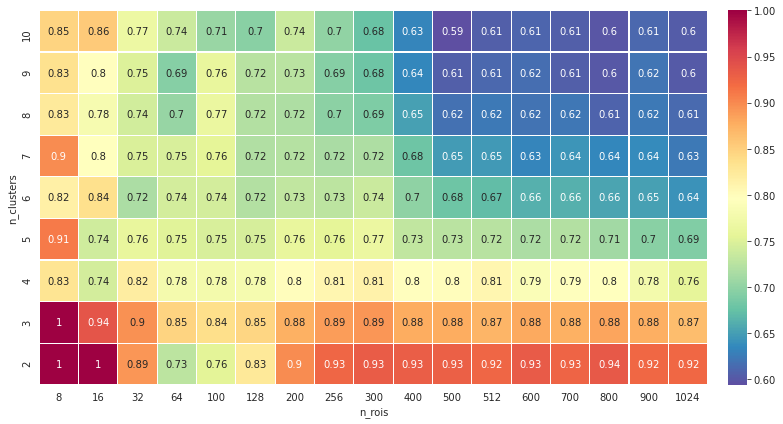

In [242]:
fig, ax = create_figure(1, 1, (12, 6), style='white')

selected_df = df.loc[df.dist_measure == 'dice']
selected_df = selected_df.groupby(['n_rois', 'n_clusters']).median()
selected_df = selected_df.unstack()

hm = selected_df.val.copy()
hm = hm.loc[:, [n < 11 for n in hm.columns]]

sns.heatmap(
    data=hm.T,
    cmap='Spectral_r',
    annot=True,
    linewidths=0.2,
    cbar_kws={'pad': 0.025},
    ax=ax,
)
ax.invert_yaxis()
fig.savefig(pjoin(tmp_dir, f"reproduc_table_hm_median_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

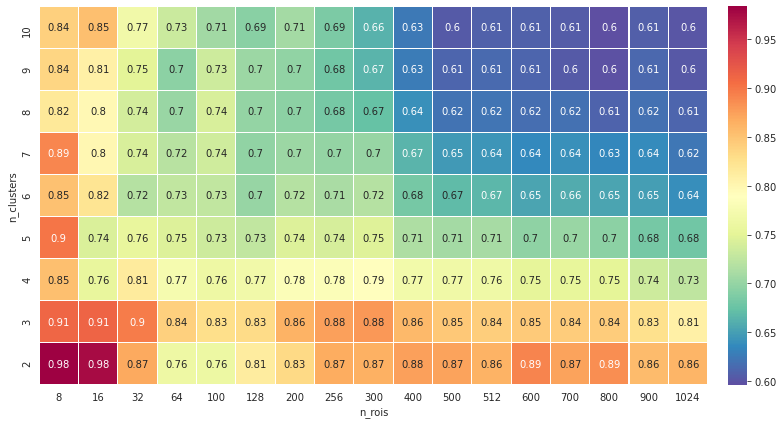

In [243]:
fig, ax = create_figure(1, 1, (12, 6), style='white')

selected_df = df.loc[df.dist_measure == 'dice']
selected_df = selected_df.groupby(['n_rois', 'n_clusters']).mean()
selected_df = selected_df.unstack()

hm = selected_df.val.copy()
hm = hm.loc[:, [n < 11 for n in hm.columns]]

sns.heatmap(
    data=hm.T,
    cmap='Spectral_r',
    annot=True,
    linewidths=0.2,
    cbar_kws={'pad': 0.025},
    ax=ax,
)
ax.invert_yaxis()
fig.savefig(pjoin(tmp_dir, f"reproduc_table_hm_mean_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

In [3]:
import math

In [4]:
math.comb(10, 5), math.comb(30, 15)

(252, 155117520)

In [5]:
mice = Mice()

In [6]:
sessions = [[i] for i in mice.cfg.ses_ids] + [list(mice.cfg.ses_ids)]
sessions

[[1], [2], [3], [1, 2, 3]]

In [7]:
import uuid
import random
rd = random.Random()
rd.seed(mice.cfg.random_state)
uuid.uuid4 = lambda: uuid.UUID(int=rd.getrandbits(128))

def _get_hex_string(id_length=8):
    return uuid.uuid4().hex[:id_length]

combos = []
for a in itertools.combinations(mice.cfg.sub_ids, mice.cfg.num_subjects // 2):
    combos.append(list(a))
pairs = [(combos[i], combos[-i - 1]) for i in range(len(combos) // 2)]
assert all(set(x[0] + x[1]) == set(mice.cfg.sub_ids) for x in pairs)

key2hex = {}
for s in [[i] for i in mice.cfg.ses_ids] + [list(mice.cfg.ses_ids)]:
    for a in combos:
        key_ses = f"ses-{','.join([str(x) for x in s])}"
        key_sub = f"sub-{','.join([str(x) for x in a])}"
        key = '_'.join([key_ses, key_sub])
        key2hex[key] = _get_hex_string()
for key in mice.bold_combined:
    key2hex[key] = _get_hex_string()

In [8]:
sub_ses = [(sub, ses) for sub in mice.cfg.sub_ids for ses in mice.cfg.ses_ids]
sub_ses

[
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 2),
    (2, 3),
    (3, 1),
    (3, 2),
    (3, 3),
    (4, 1),
    (4, 2),
    (4, 3),
    (5, 1),
    (5, 2),
    (5, 3),
    (6, 1),
    (6, 2),
    (6, 3),
    (7, 1),
    (7, 2),
    (7, 3),
    (8, 1),
    (8, 2),
    (8, 3),
    (9, 1),
    (9, 2),
    (9, 3),
    (10, 1),
    (10, 2),
    (10, 3)
]

In [9]:
ctr = 0
for item in itertools.combinations(sub_ses, len(sub_ses) // 2):
    key = ','.join(['-'.join([str(i) for i in x]) for x in item])
    key = f"sub-ses_{key}"
    print(item, key)
    ctr +=1
    if ctr >= 1:
        break

(
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 2),
    (2, 3),
    (3, 1),
    (3, 2),
    (3, 3),
    (4, 1),
    (4, 2),
    (4, 3),
    (5, 1),
    (5, 2),
    (5, 3)
)
sub-ses_1-1,1-2,1-3,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,4-3,5-1,5-2,5-3

In [10]:
key

'sub-ses_1-1,1-2,1-3,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,4-3,5-1,5-2,5-3'

In [11]:
key.split('_')

['sub-ses', '1-1,1-2,1-3,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,4-3,5-1,5-2,5-3']

In [12]:
[tuple(int(i) for i in x.split('-')) for x in key.split('_')[-1].split(',')]

[
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 2),
    (2, 3),
    (3, 1),
    (3, 2),
    (3, 3),
    (4, 1),
    (4, 2),
    (4, 3),
    (5, 1),
    (5, 2),
    (5, 3)
]

In [13]:
tuple(zip(*[tuple(int(i) for i in x.split('-')) for x in key.split('_')[-1].split(',')]))

(
    (1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5),
    (1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3)
)

In [70]:
"""import uuid
import random
rd = random.Random()
rd.seed(mice.cfg.random_state)
uuid.uuid4 = lambda: uuid.UUID(int=rd.getrandbits(128))

def _get_hex_string(id_length=8):
    return uuid.uuid4().hex[:id_length]

combos = []
for a in itertools.combinations(mice.cfg.sub_ids, mice.cfg.num_subjects // 2):
    combos.append(list(a))
pairs = [(combos[i], combos[-i - 1]) for i in range(len(combos) // 2)]
assert all(set(x[0] + x[1]) == set(mice.cfg.sub_ids) for x in pairs)

key2hex = {}
for s in [[i] for i in mice.cfg.ses_ids] + [list(mice.cfg.ses_ids)]:
    for a in combos:
        key_ses = f"ses-{','.join([str(x) for x in s])}"
        key_sub = f"sub-{','.join([str(x) for x in a])}"
        key = '_'.join([key_ses, key_sub])
        key2hex[key] = _get_hex_string()
print(len(key2hex))

sub_ses = [
    (sub, ses)
    for sub in mice.cfg.sub_ids
    for ses in mice.cfg.ses_ids
]
for c in tqdm(itertools.combinations(sub_ses, len(sub_ses) // 2)):
    key = ','.join(['-'.join([str(i) for i in x]) for x in c])
    key = f"sub-ses_{key}"
    key2hex[key] = _get_hex_string()
print(len(key2hex))

for key in mice.bold_combined:
    key2hex[key] = _get_hex_string()

hex2key = {h: k for k, h in key2hex.items()}
len(hex2key)"""

1008

0it [00:00, ?it/s]

155118528

152349842

In [36]:
sub_ses = [
    (sub, ses)
    for sub in mice.cfg.sub_ids
    for ses in mice.cfg.ses_ids
]
sub_ses = np.array(sub_ses)

rng = np.random.RandomState(0)

In [65]:
def sample(n, total):
    samples = []
    while True:
        idxs = rng.choice(range(total), size=total//2, replace=False)
        idxs = sorted(idxs)
        if idxs not in samples:
            samples.append(idxs)
            if len(samples) == n:
                break
    return samples

In [89]:
samples = sample(100, len(sub_ses))
len(samples)

100

In [90]:
%timeit sample(100, len(sub_ses))

2.78 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
%timeit sample(1000, len(sub_ses))

54.3 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
%timeit sample(10000, len(sub_ses))

4.12 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
total = len(sub_ses)
idxs = rng.choice(range(total), size=total//2, replace=False)
idxs = sorted(idxs)
idxs

[2, 5, 8, 10, 11, 13, 14, 16, 17, 22, 23, 24, 26, 27, 28]

In [38]:
sub_ses[idxs]

array([[ 1,  3],
       [ 2,  3],
       [ 3,  3],
       [ 4,  2],
       [ 4,  3],
       [ 5,  2],
       [ 5,  3],
       [ 6,  2],
       [ 6,  3],
       [ 8,  2],
       [ 8,  3],
       [ 9,  1],
       [ 9,  3],
       [10,  1],
       [10,  2]])

In [39]:
key = ','.join(['-'.join([str(i) for i in x]) for x in sub_ses[idxs]])
key = f"sub-ses_{key}"
key

'sub-ses_1-3,2-3,3-3,4-2,4-3,5-2,5-3,6-2,6-3,8-2,8-3,9-1,9-3,10-1,10-2'

In [17]:
len(sub_ses)

30